In [1]:
from google.colab import files
uploaded = files.upload()

Saving DROME_SAILLANS.csv to DROME_SAILLANS.csv


In [2]:
!git clone https://github.com/mmazzolini/Runoff_prediction.git


Cloning into 'Runoff_prediction'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 234 (delta 109), reused 191 (delta 70), pack-reused 0
Receiving objects: 100% (234/234), 167.06 MiB | 26.95 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Checking out files: 100% (88/88), done.


In [42]:
import sys, importlib
importlib.reload(sys.modules['nested_CV'])

<module 'nested_CV' from '/content/Runoff_prediction/nested_CV.py'>

In [3]:


import sys
sys.path.insert(0, "/content/Runoff_prediction")
#sys.path.insert(0, "/content/functions")



from base_f import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from cross_validation_f import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from cross_validation_f import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

## A) ALL_VARS, T_UNIT = 30

In [4]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\old\\'

#daily_input = pd.read_csv(path+'DROME_SAILLANS.csv', index_col=0, parse_dates=True)
daily_input = pd.read_csv('/content/DROME_SAILLANS.csv', index_col=0, parse_dates=True)

daily_input_stat = spatial_stats_daily_input(daily_input)
#daily_input_stat=daily_input_stat[daily_input_stat.index.dayofyear%2==1]

t_unit= 30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-5, -3, 5)
epsilon_range=np.logspace(-2.5, 0, 5)

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365


daily_input_stat=daily_input_stat.iloc[2:]

Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits

C3=0.00031622776601683794
eps3=0.01333521432163324


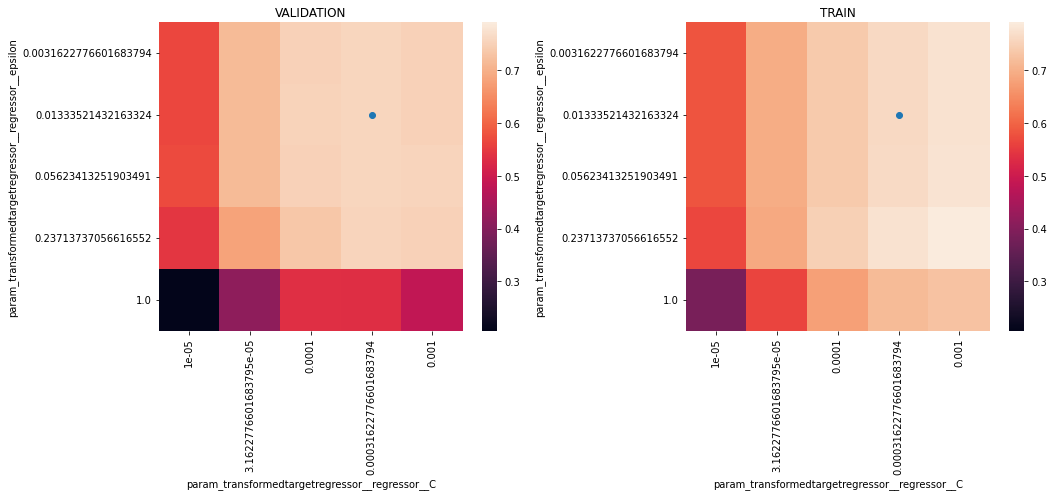

In [17]:
C, eps = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,linear=True)
print(f'C={C}')
print(f'eps={eps}') 

In [5]:
C=0.00031622776601683794
eps=0.01333521432163324

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [6]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble,linear=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

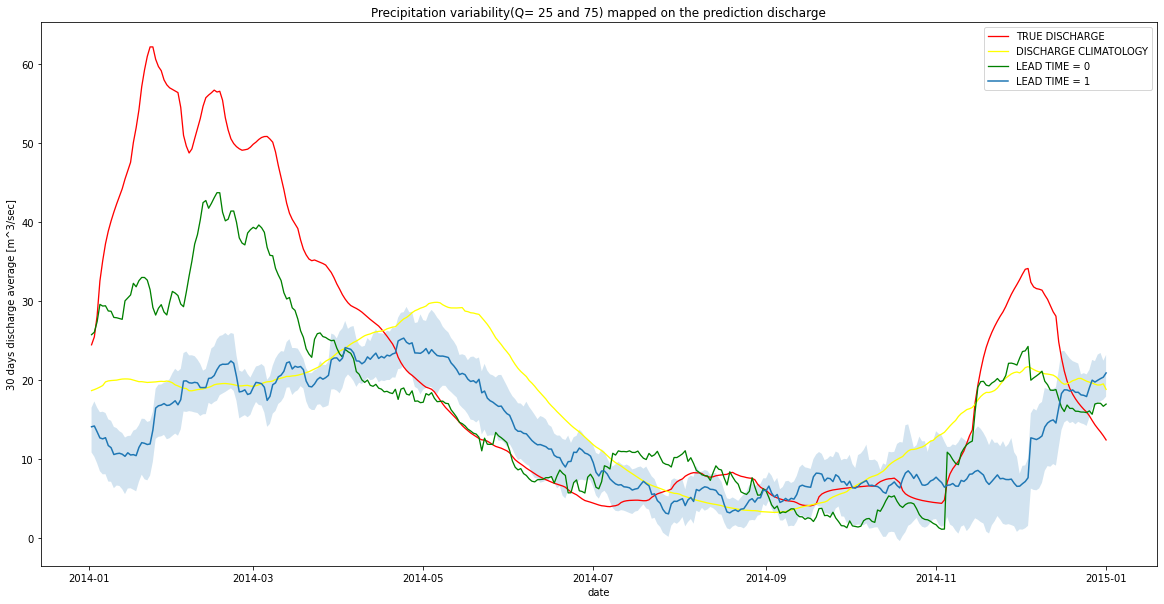

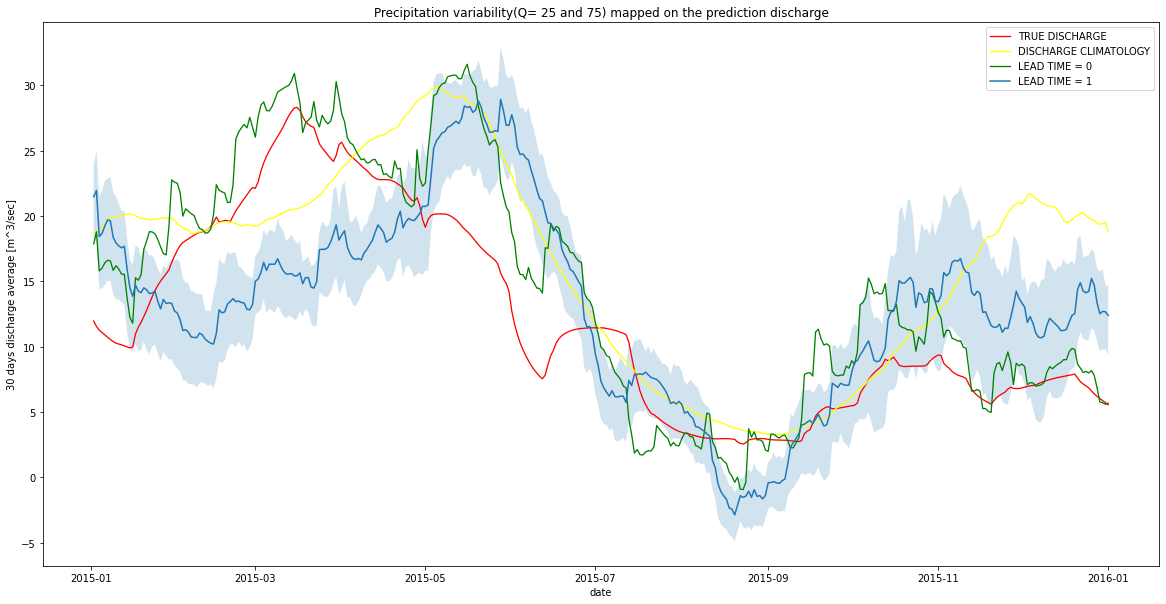

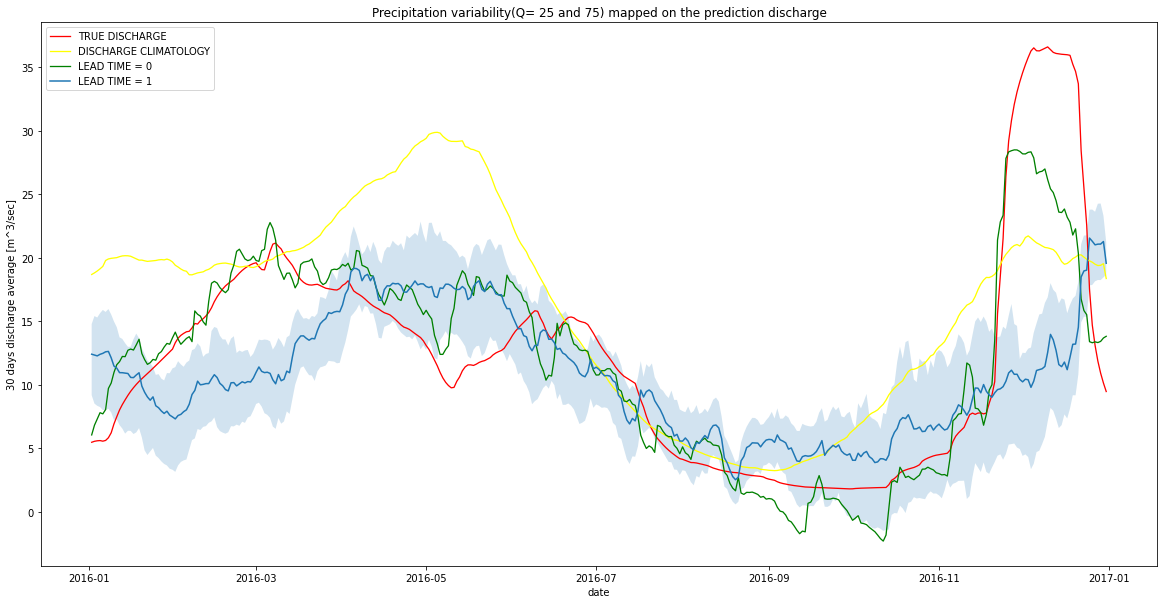

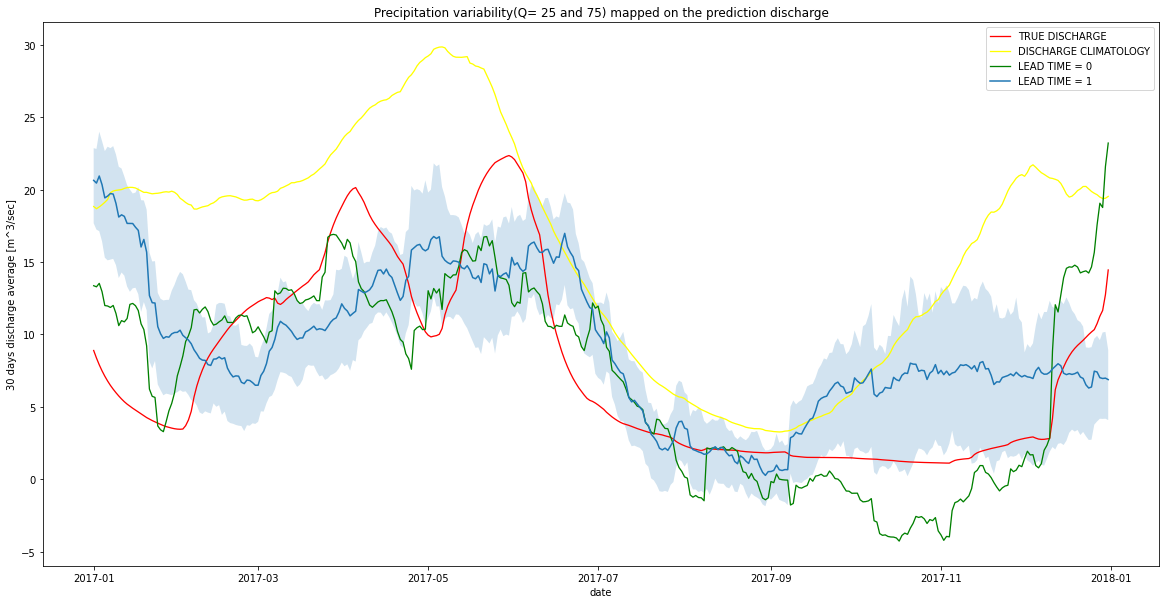

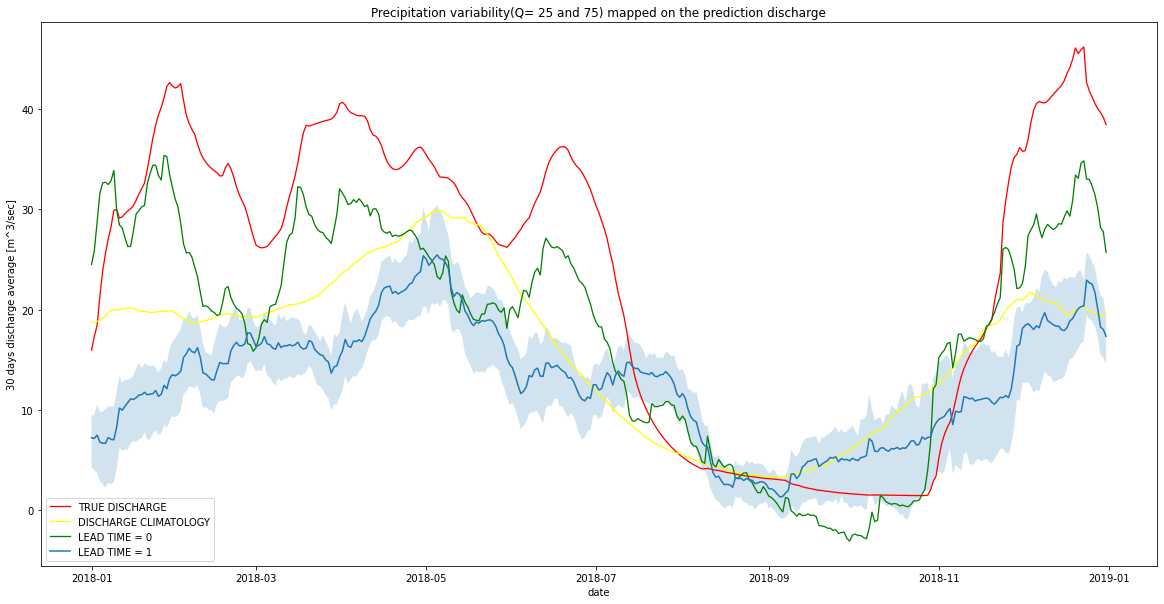

In [7]:

#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)

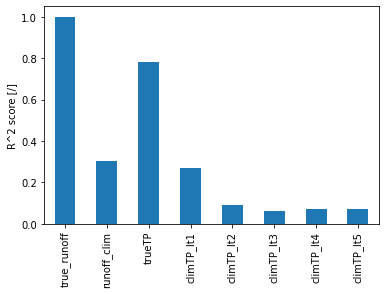

In [8]:
r2_A= evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [9]:
predictions_for_clim = classic_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits,linear=True)

In [10]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.dayofyear).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


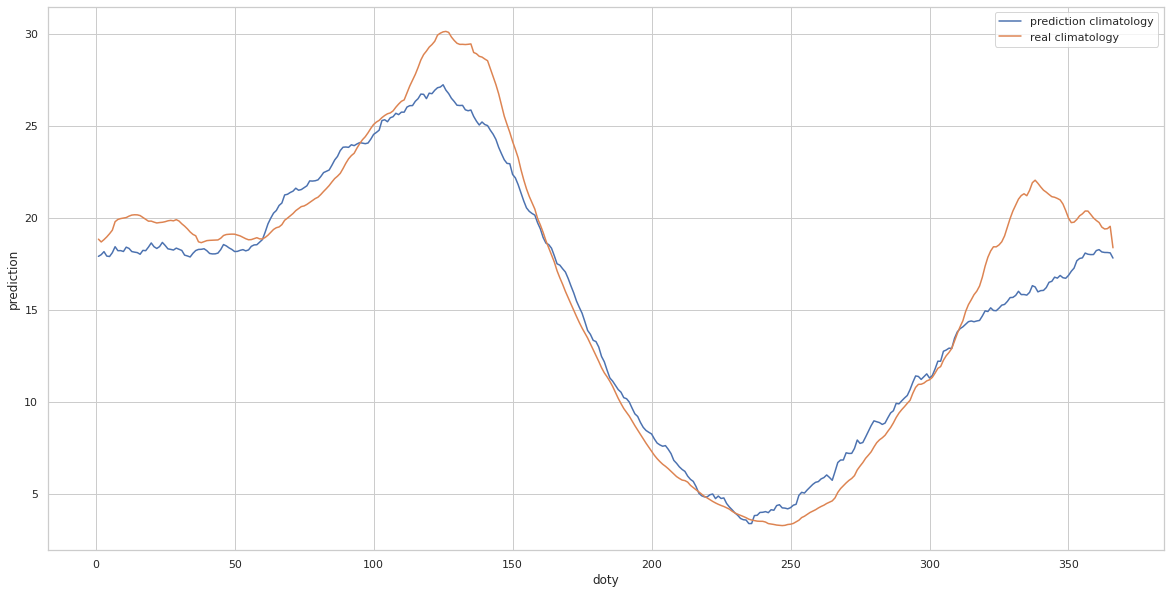

In [11]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

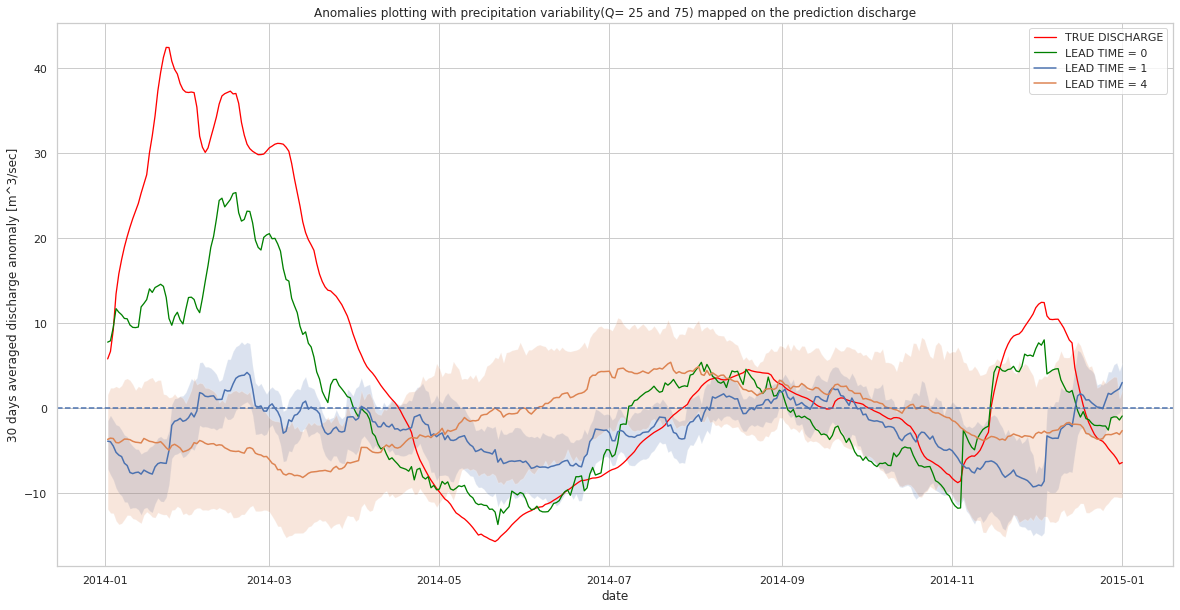

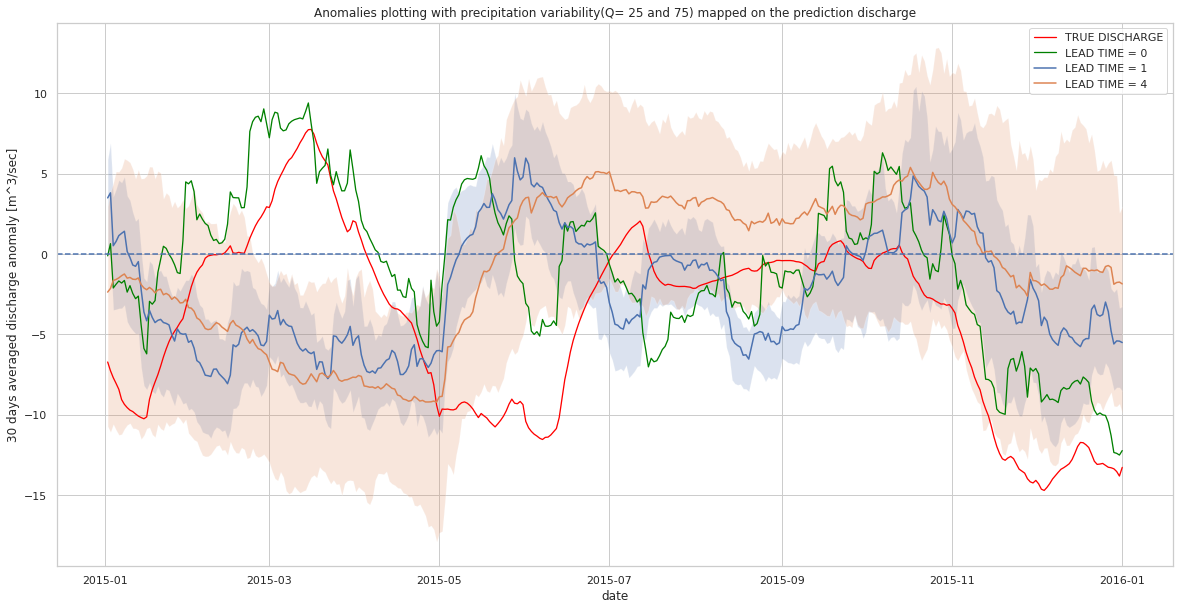

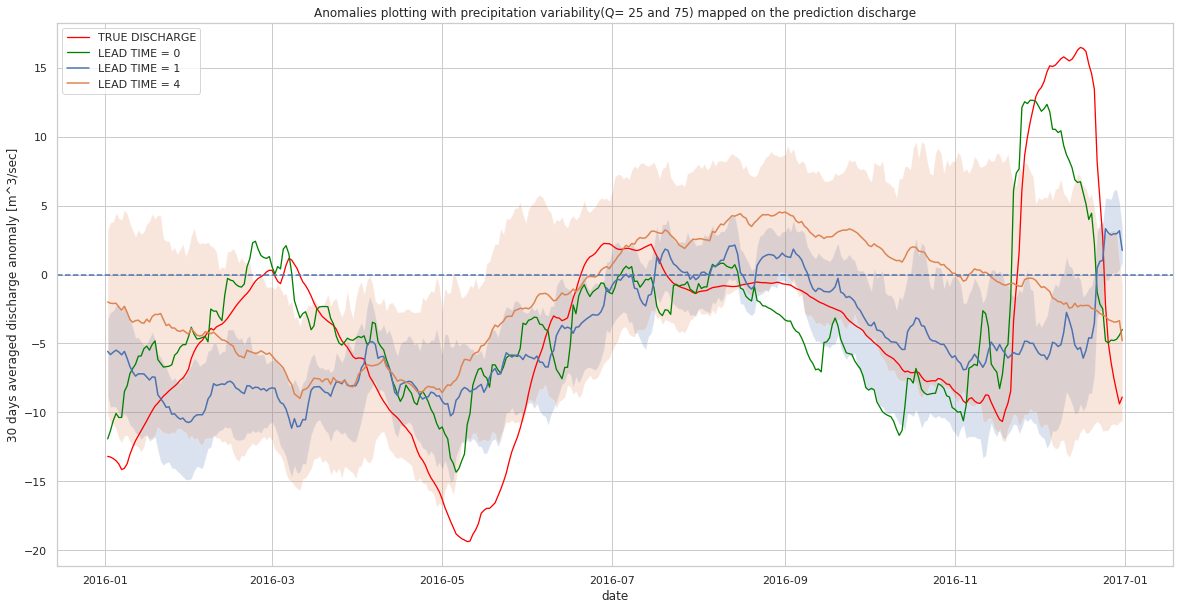

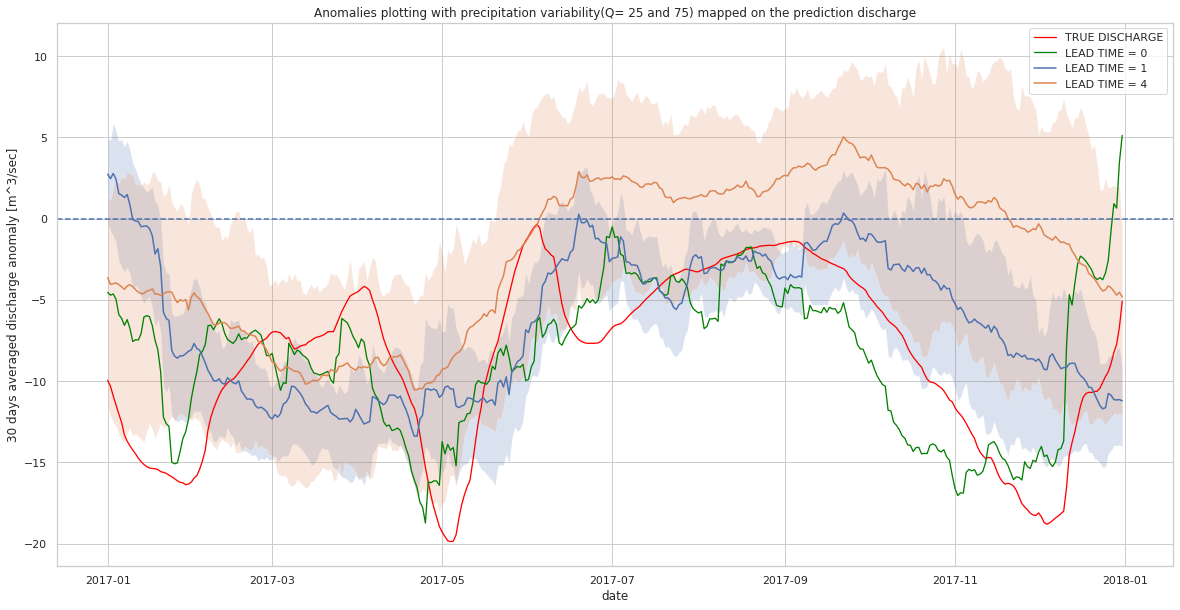

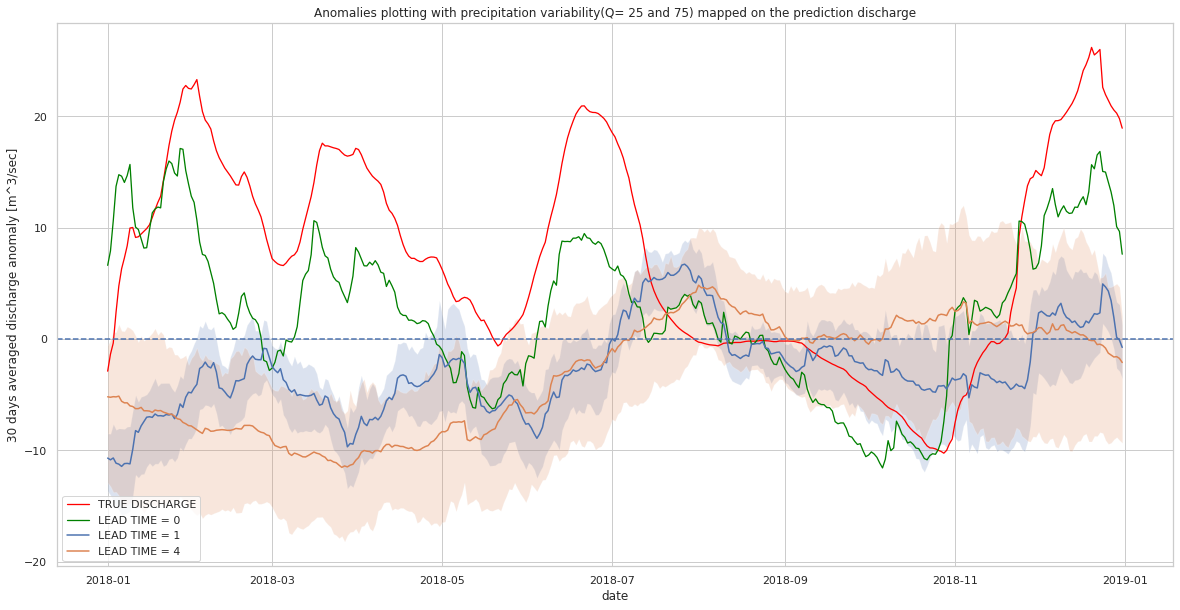

In [12]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split

plot_anomalies(a)

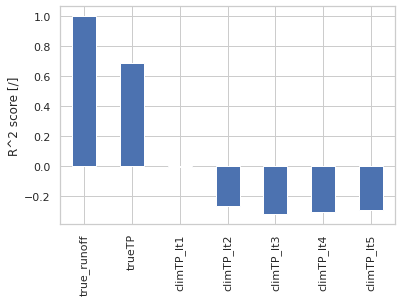

In [13]:
r2_A_a= evaluate_prediction(a)

## B) NO_SNOW, T_UNIT = 30

In [13]:
daily_input_stat2 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])


In [14]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-5, -2, 6)
epsilon_range=np.logspace(-3, -0.5, 5)

#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=5
test_size=365

In [22]:
C2, eps2 = SVR_nested_CV_gridsearch(daily_input_stat2, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,linear=True)
print(f'C2={C2}')
print(f'eps2={eps2}')

TypeError: ignored

In [15]:
C2=3.9810717055349695e-05
eps2=0.01778279410038923

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [16]:
radius_for_ensemble = 1
predictions2 = nested_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits, test_size, radius_for_ensemble, linear=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

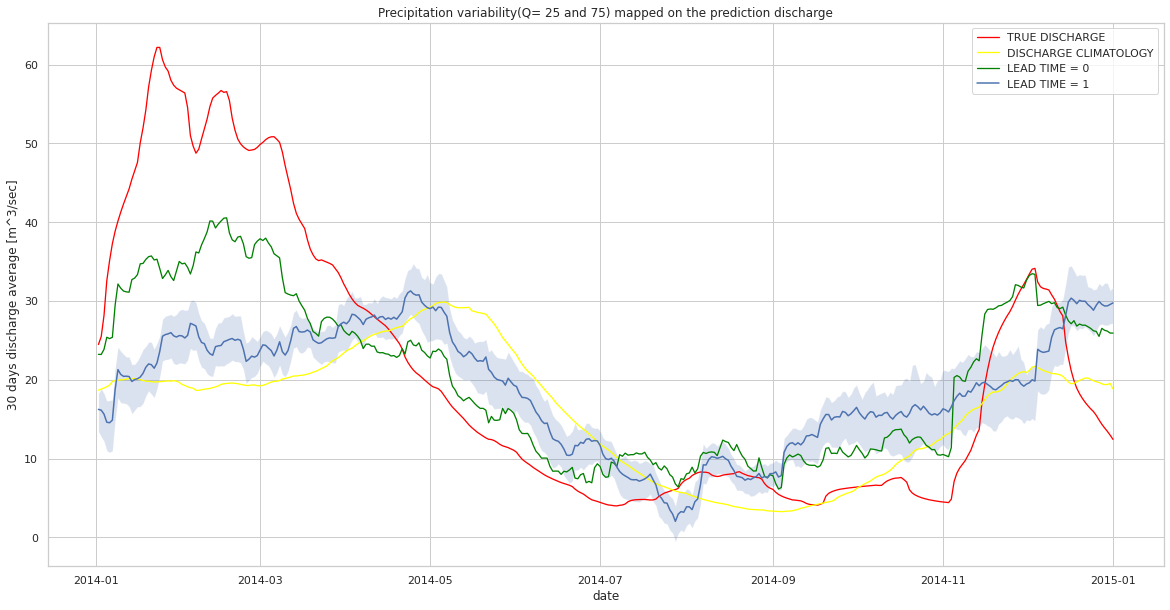

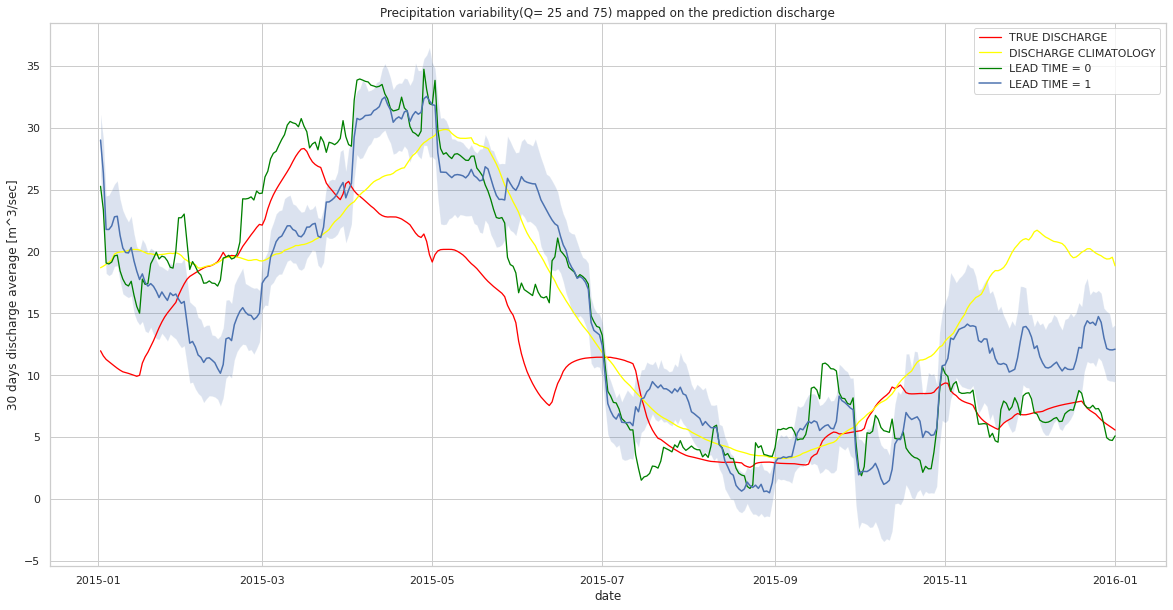

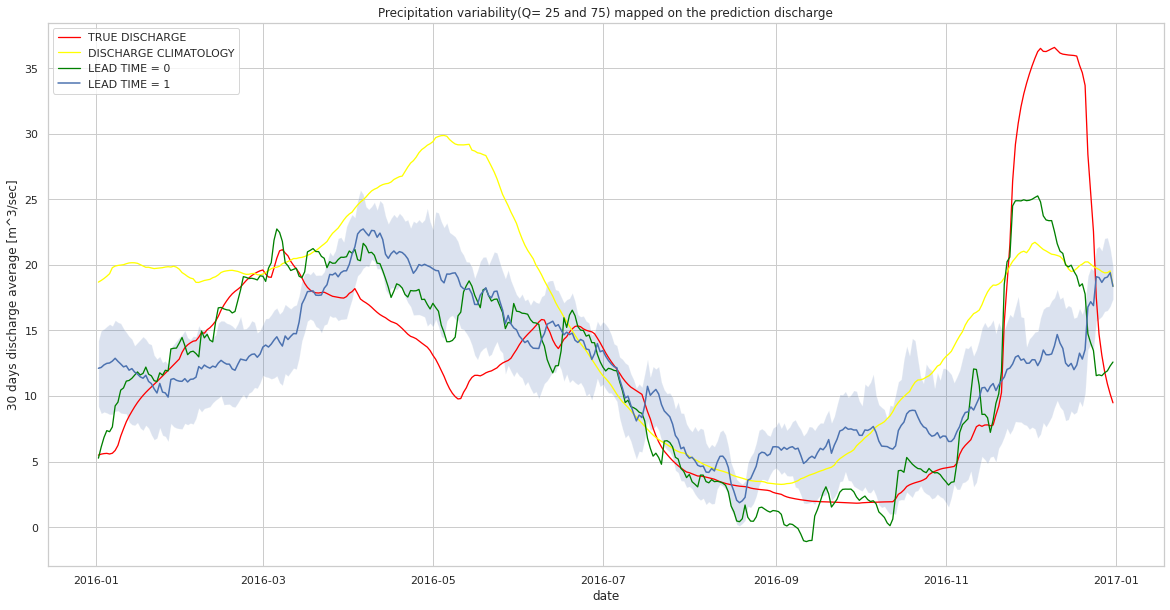

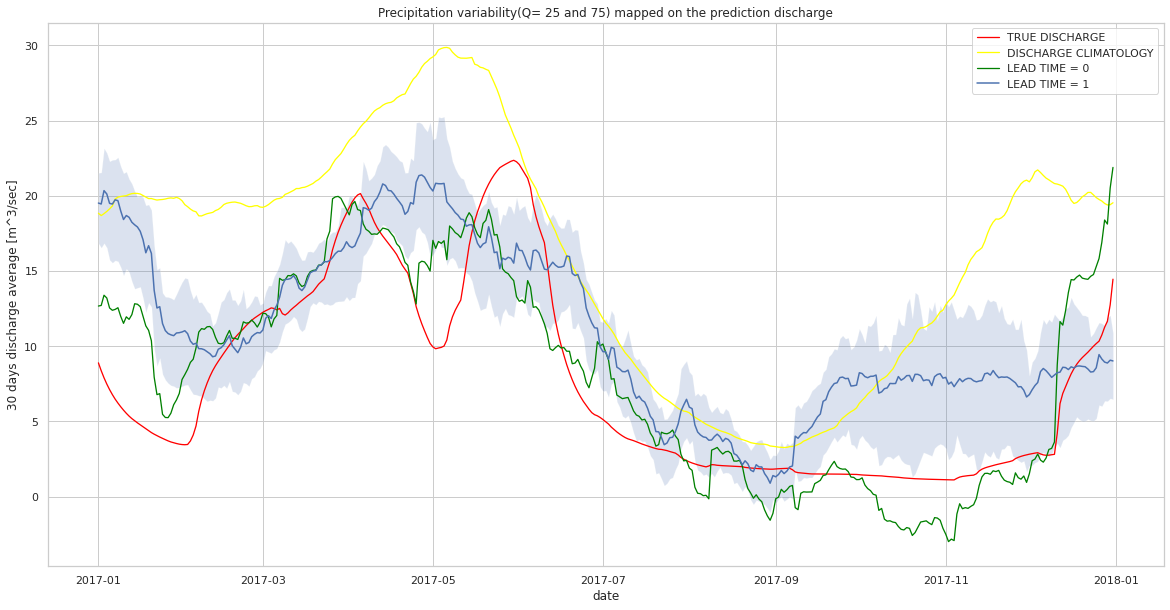

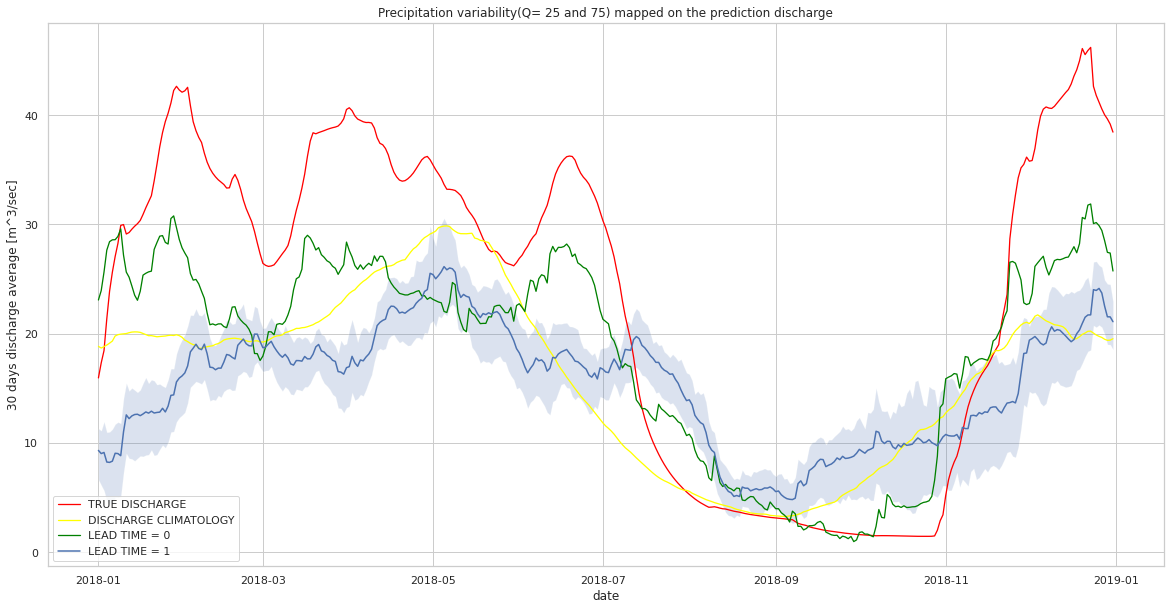

In [17]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions2)

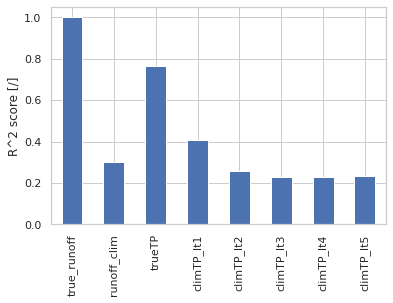

In [18]:
r2_B= evaluate_prediction(predictions2)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [19]:
predictions_for_clim2 = classic_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits,linear=True)

In [20]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.dayofyear).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


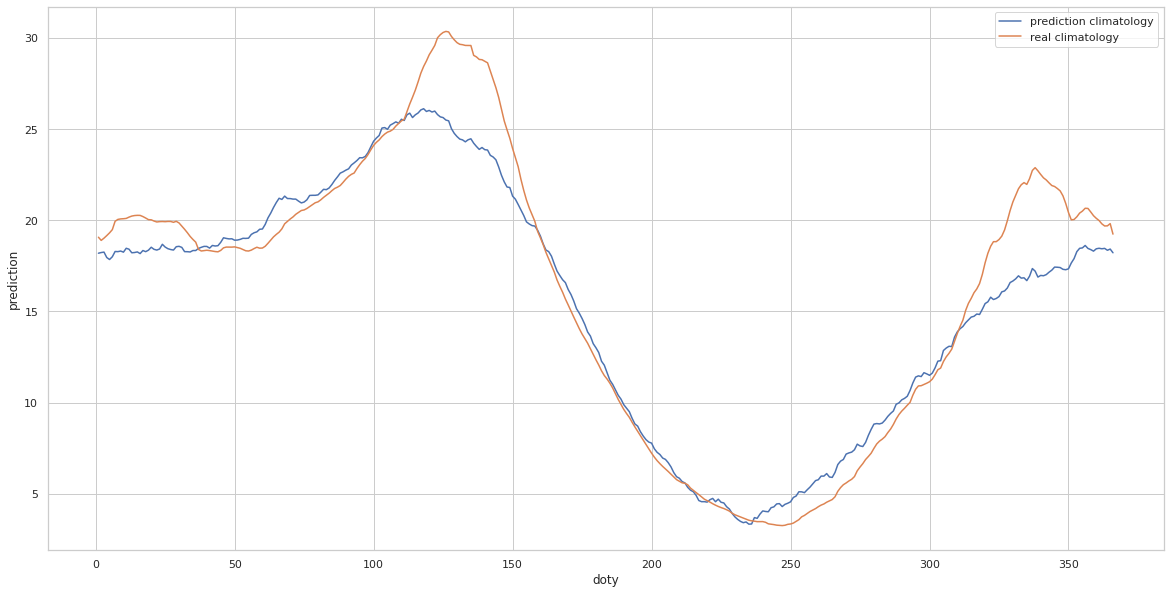

In [21]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

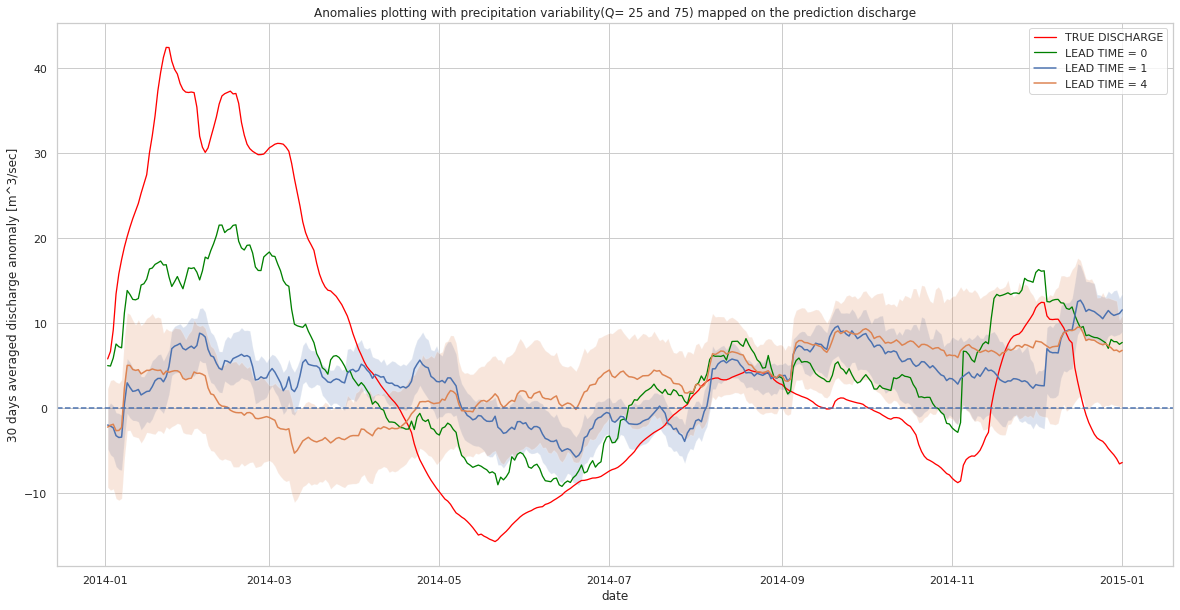

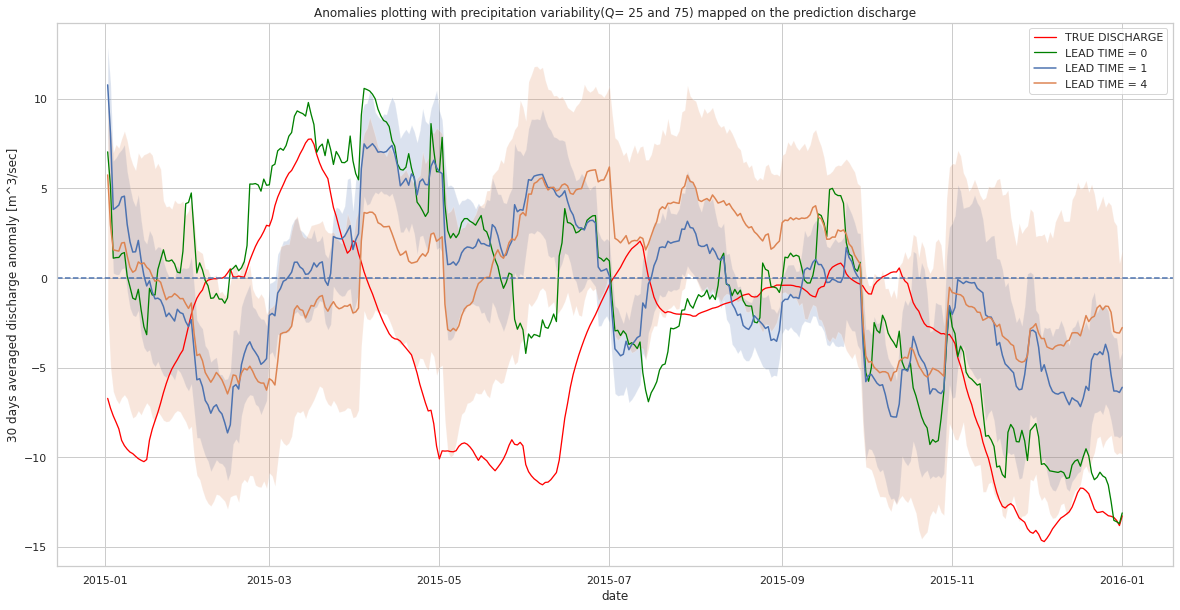

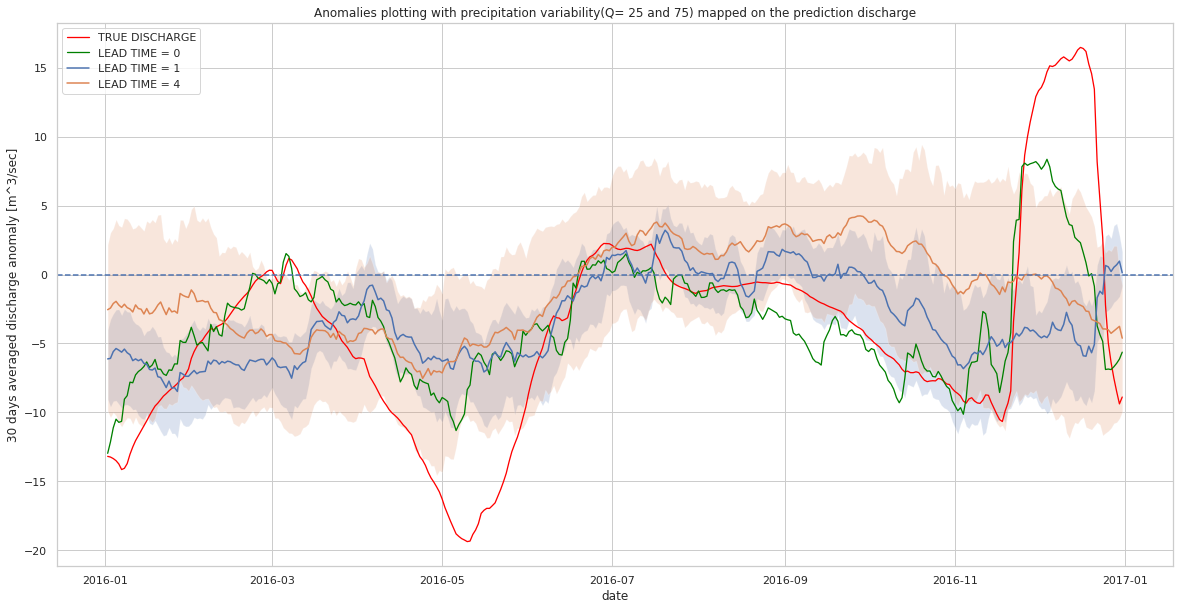

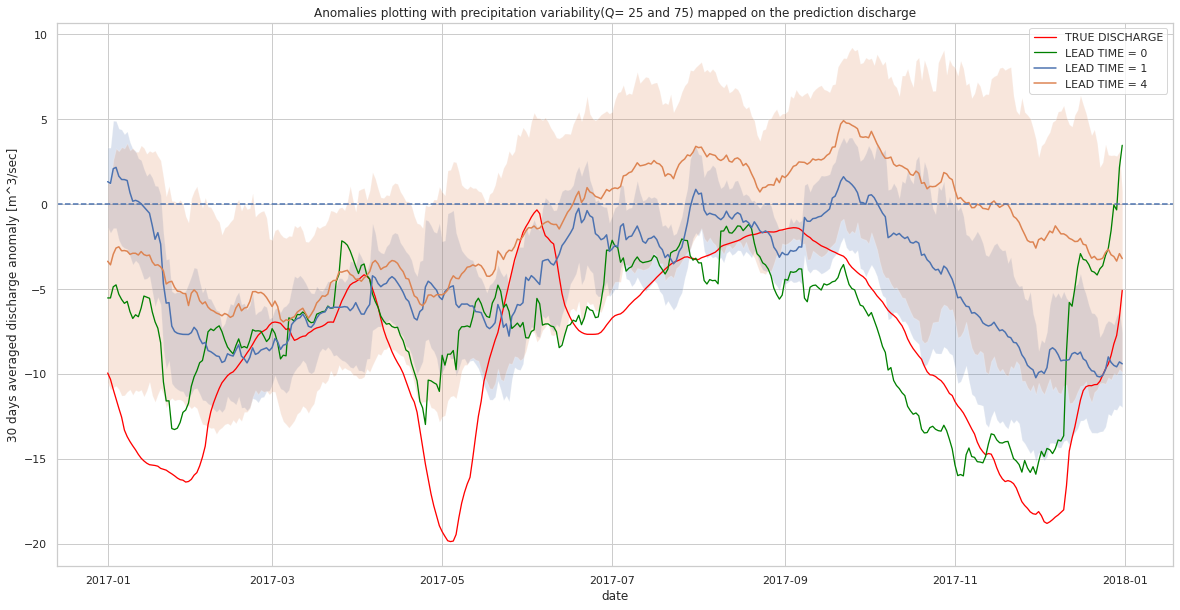

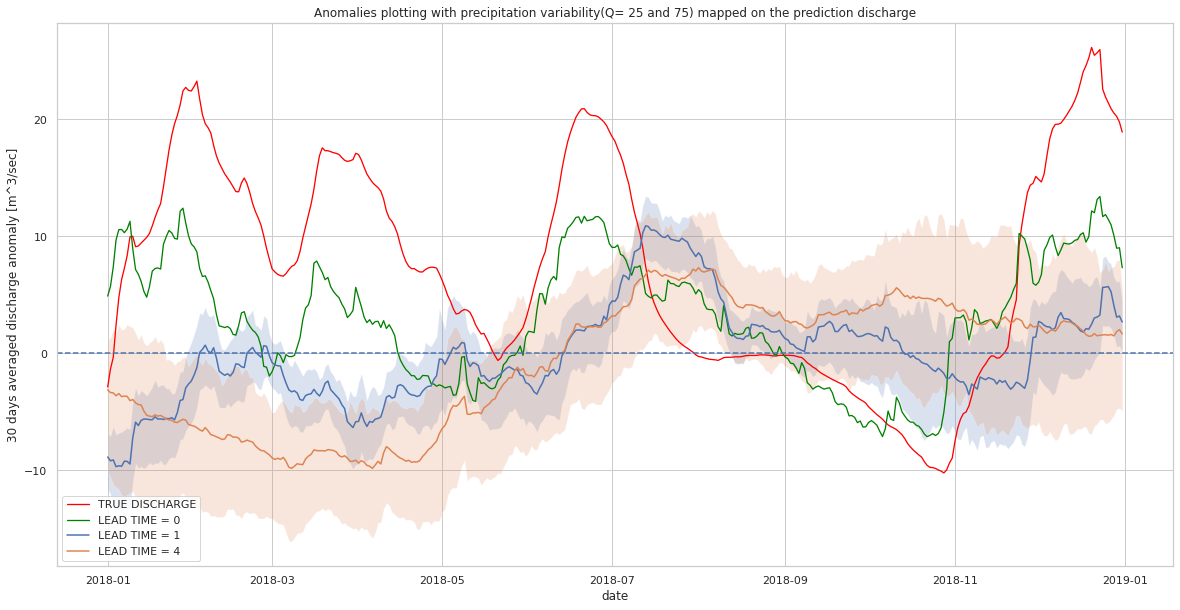

In [22]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2)

## C) NO_EVAP, T_UNIT = 30

In [23]:
daily_input_stat3 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='E'])

t_unit=30

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits

C3=3.9810717055349695e-05
eps3=0.01778279410038923


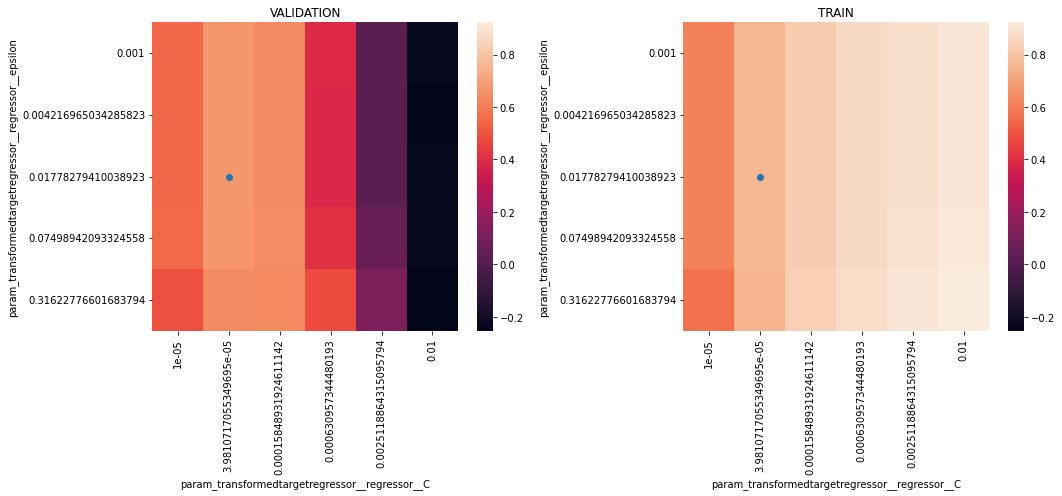

In [41]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat3, C_range, epsilon_range, t_range, t_unit, n_splits, test_size,linear=True)
print(f'C3={C3}')
print(f'eps3={eps3}')

In [24]:
C3=3.9810717055349695e-05
eps3=0.01778279410038923

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [25]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits, test_size, radius_for_ensemble,linear=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

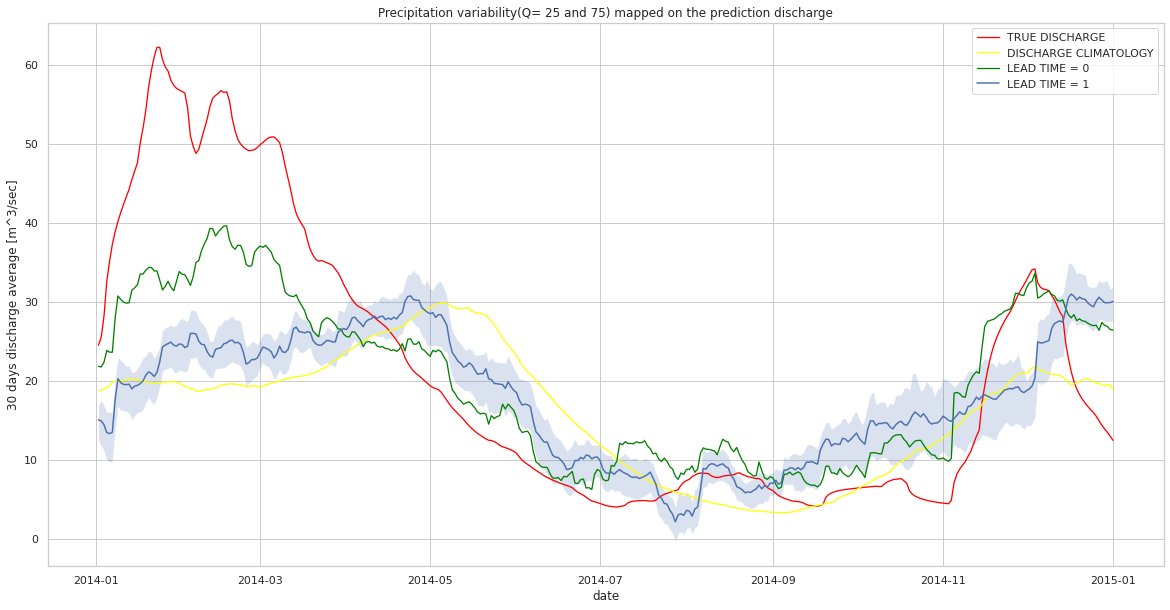

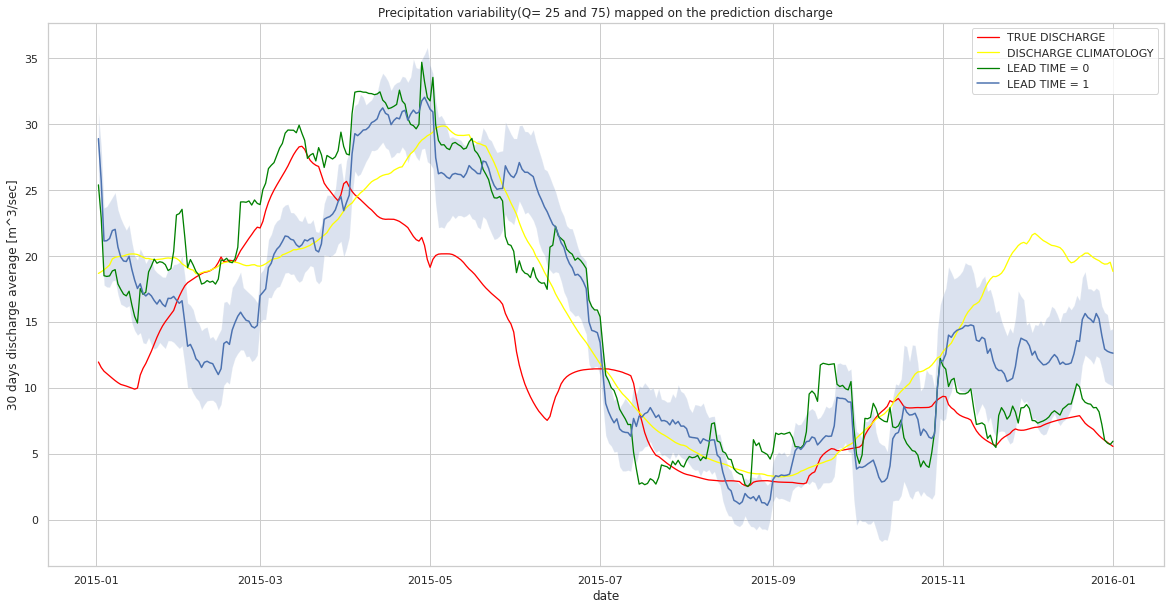

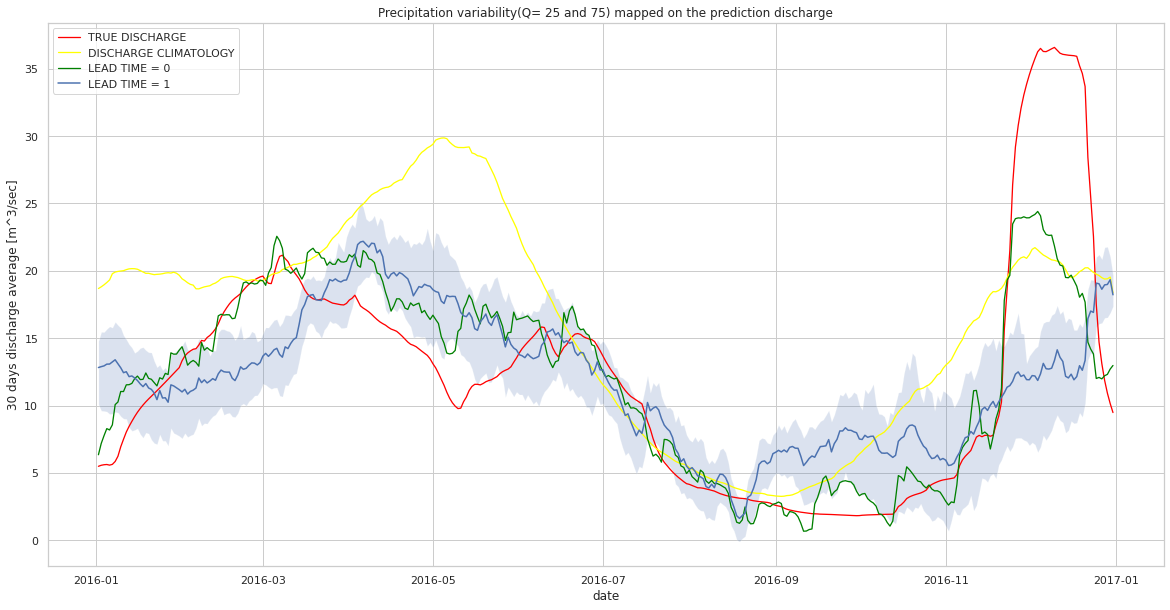

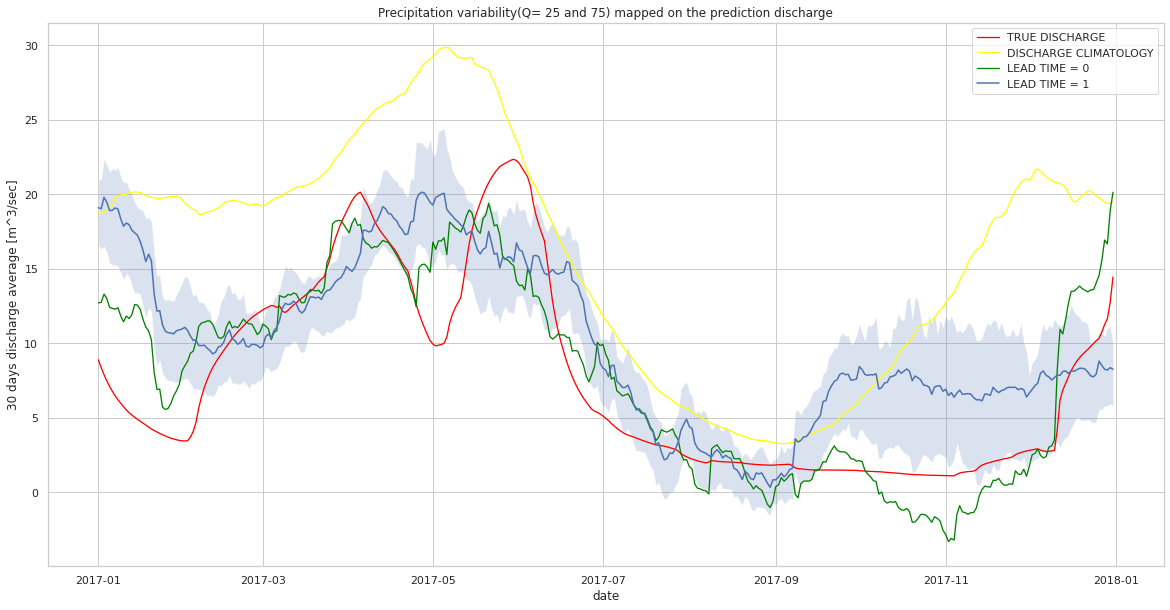

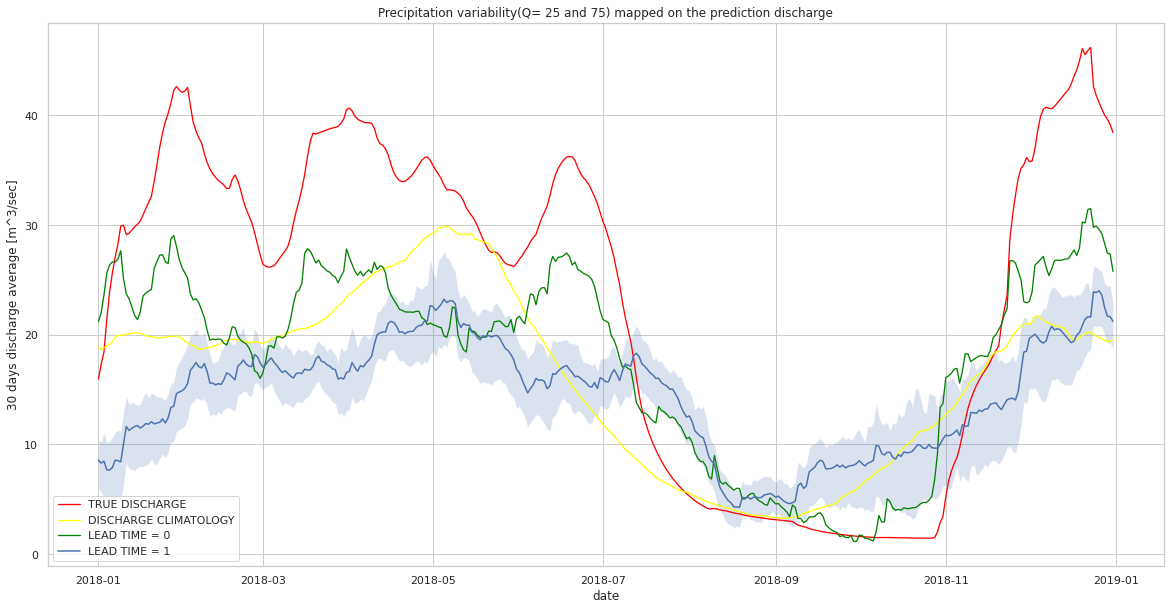

In [26]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

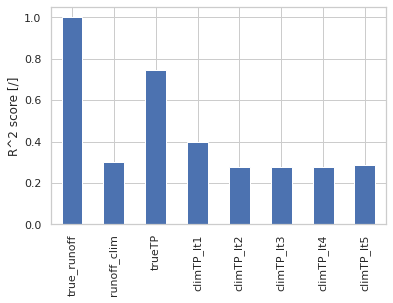

In [27]:
r2_C= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [28]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits,linear=True)

In [29]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.dayofyear).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


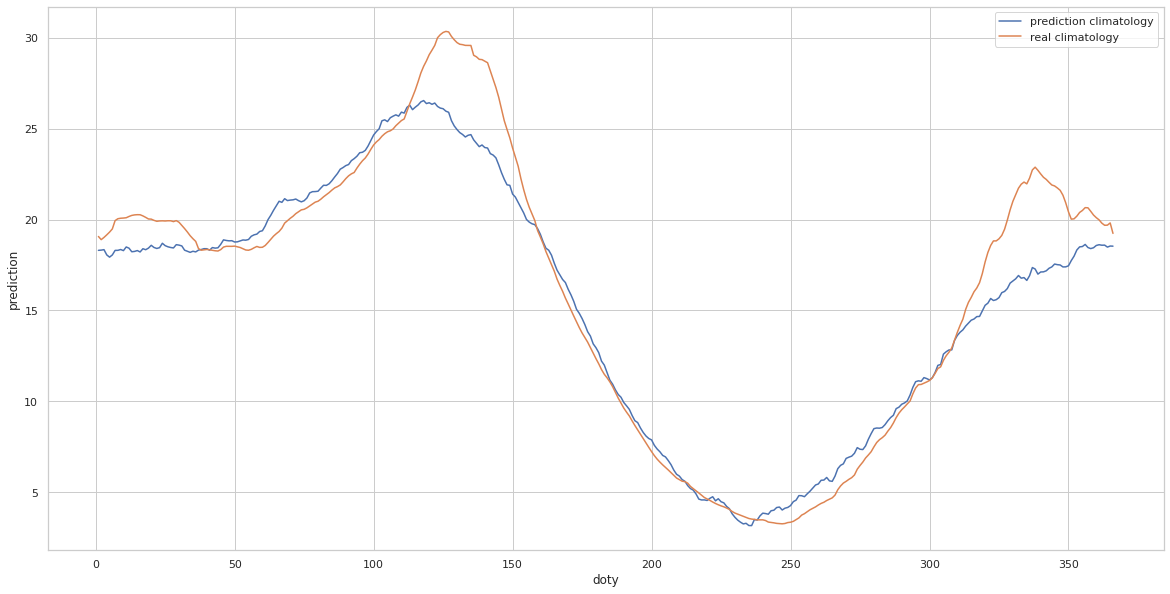

In [30]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

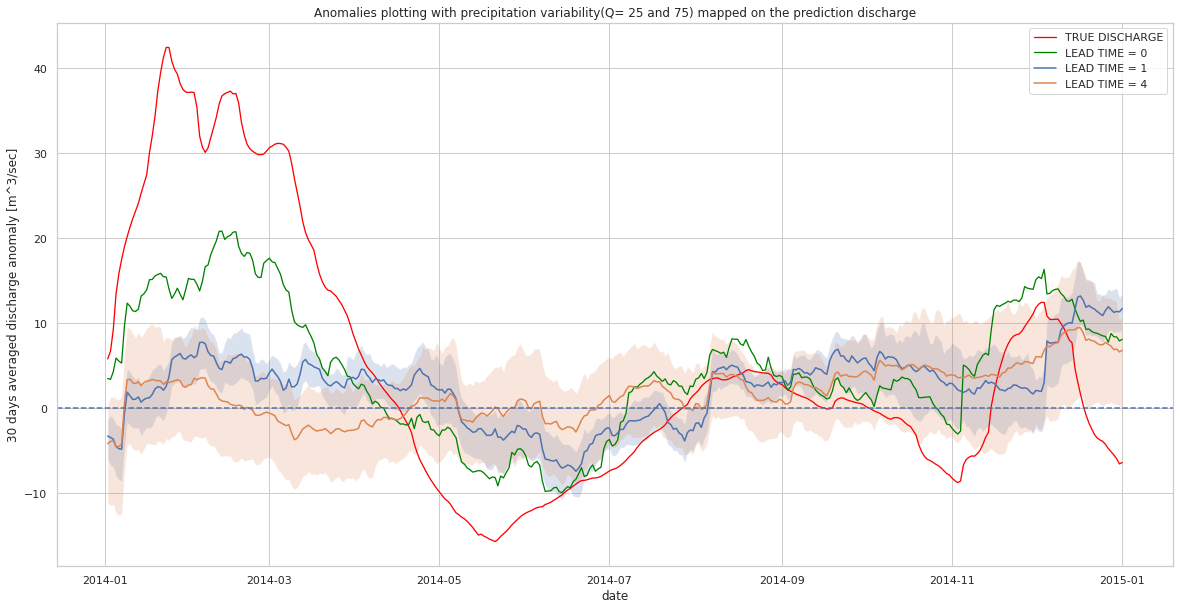

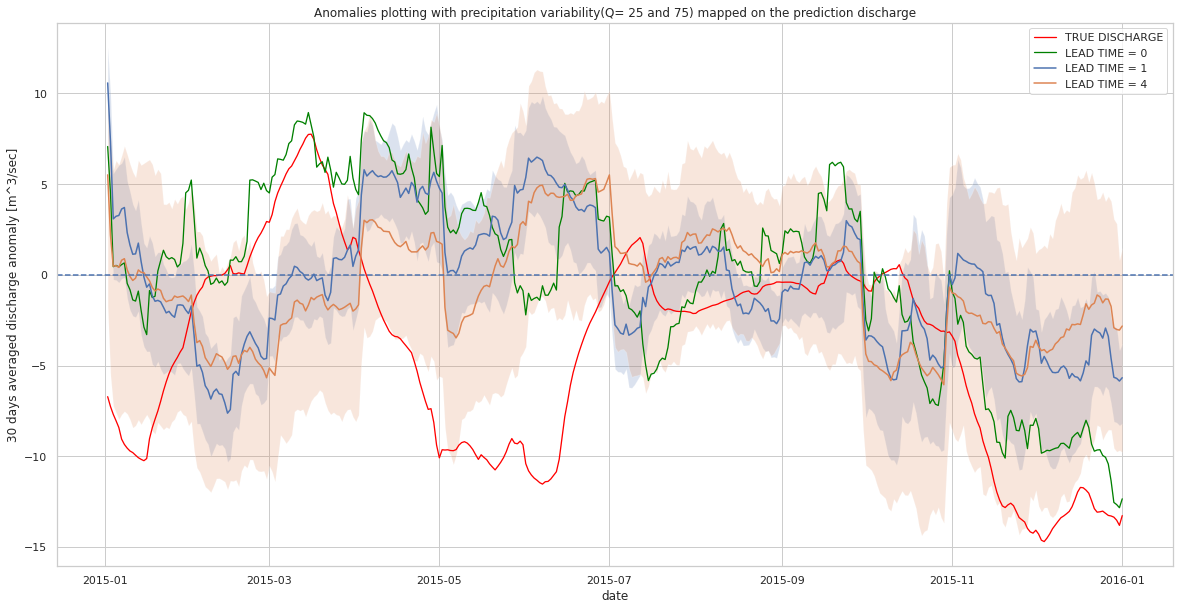

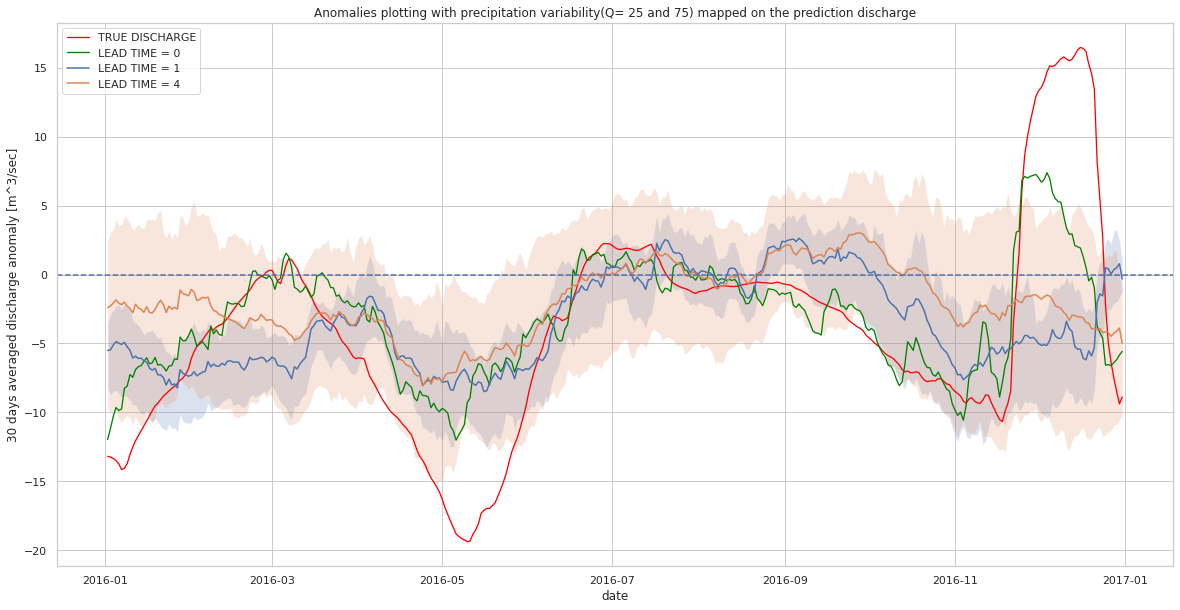

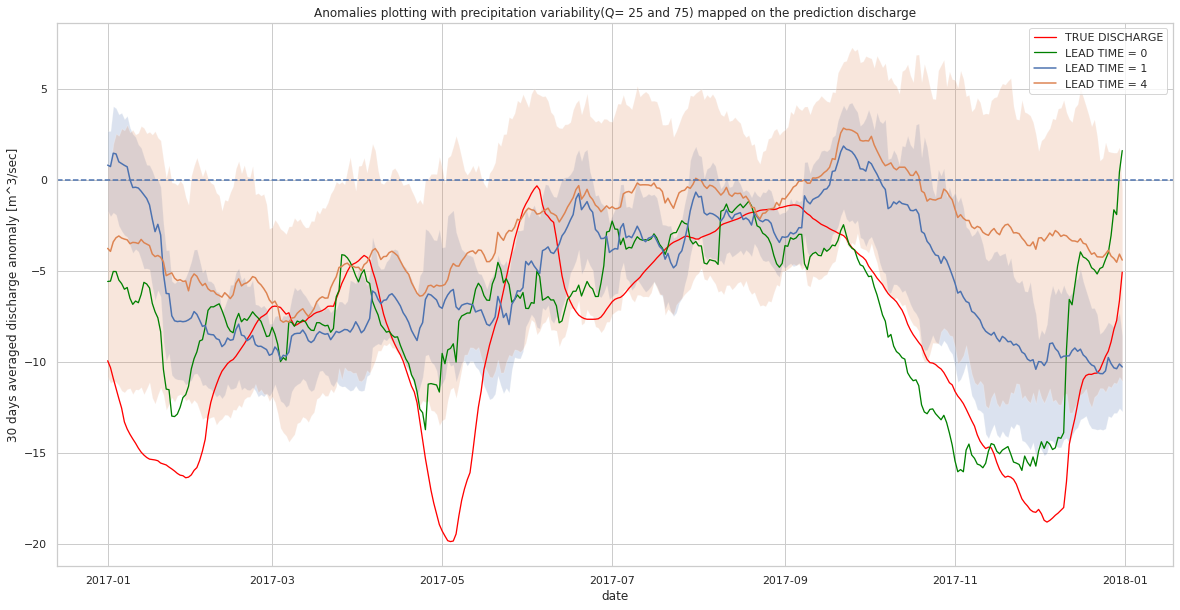

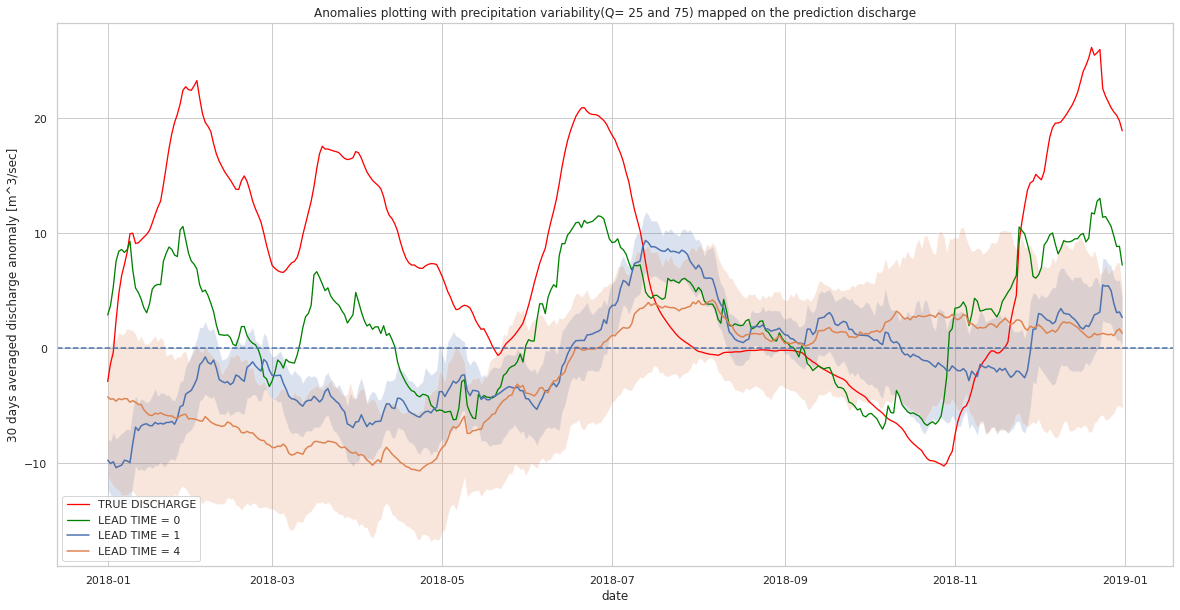

In [31]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

## D) NO_RUNOFF, T_UNIT = 30

In [40]:
daily_input_stat4 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='R'])

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits

C4=0.00015848931924611142
eps4=0.01778279410038923


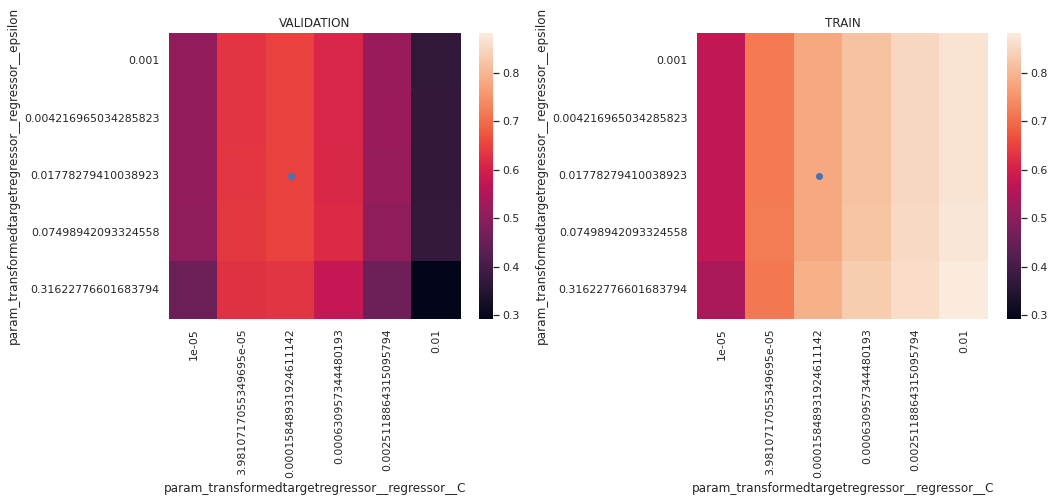

In [45]:
C4, eps4 = SVR_nested_CV_gridsearch(daily_input_stat4, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,linear=True)
print(f'C4={C4}')
print(f'eps4={eps4}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [46]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat4, C4, eps4, t_length, t_unit, n_splits, test_size, radius_for_ensemble,linear=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

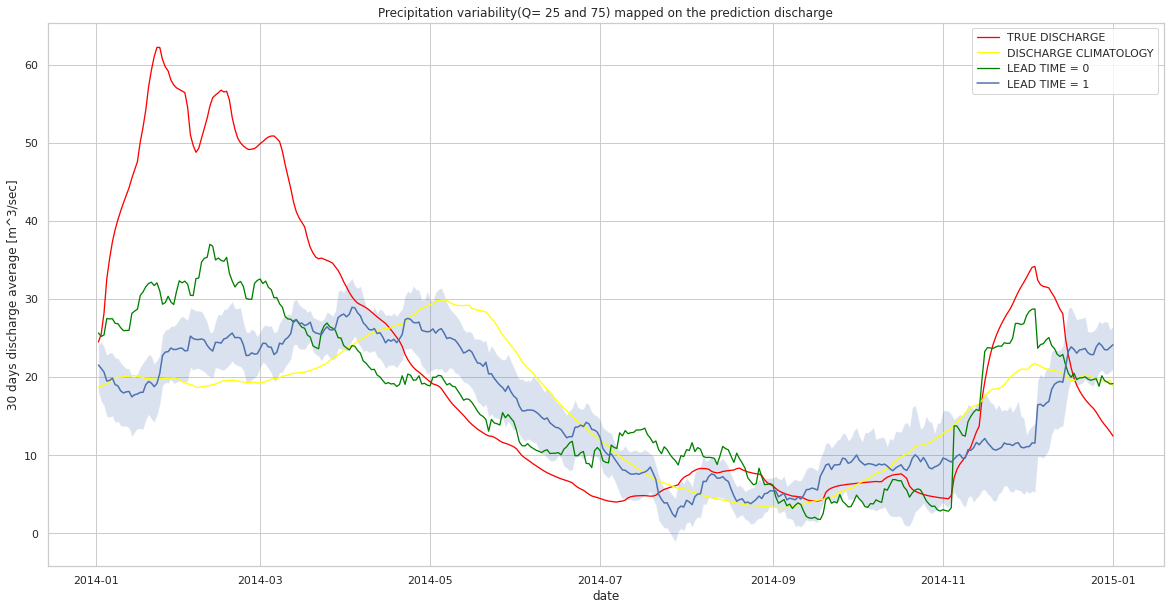

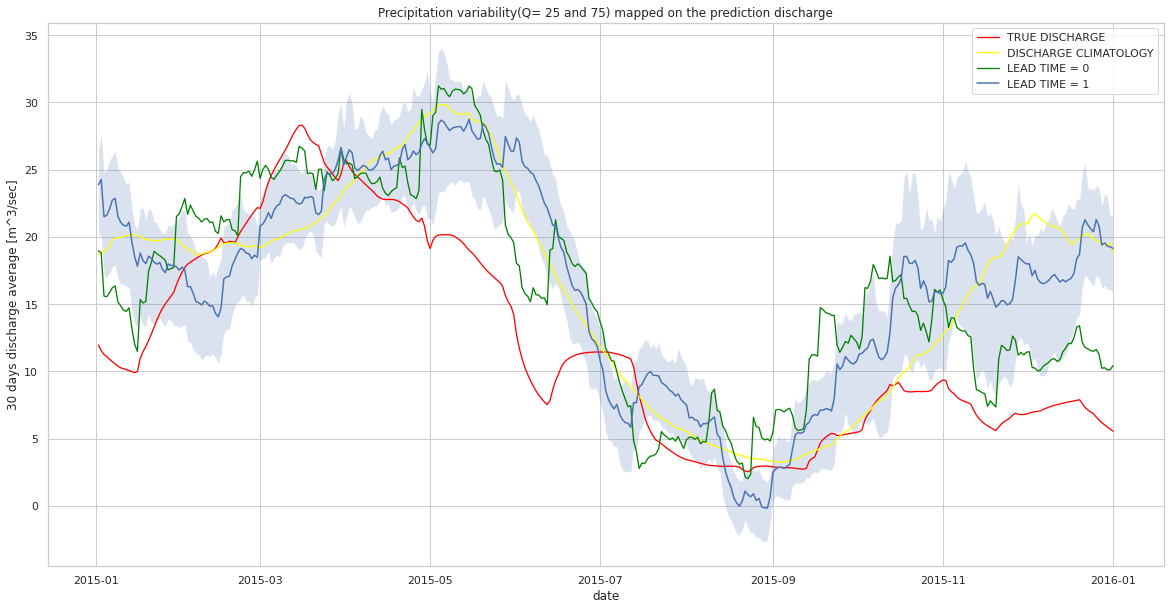

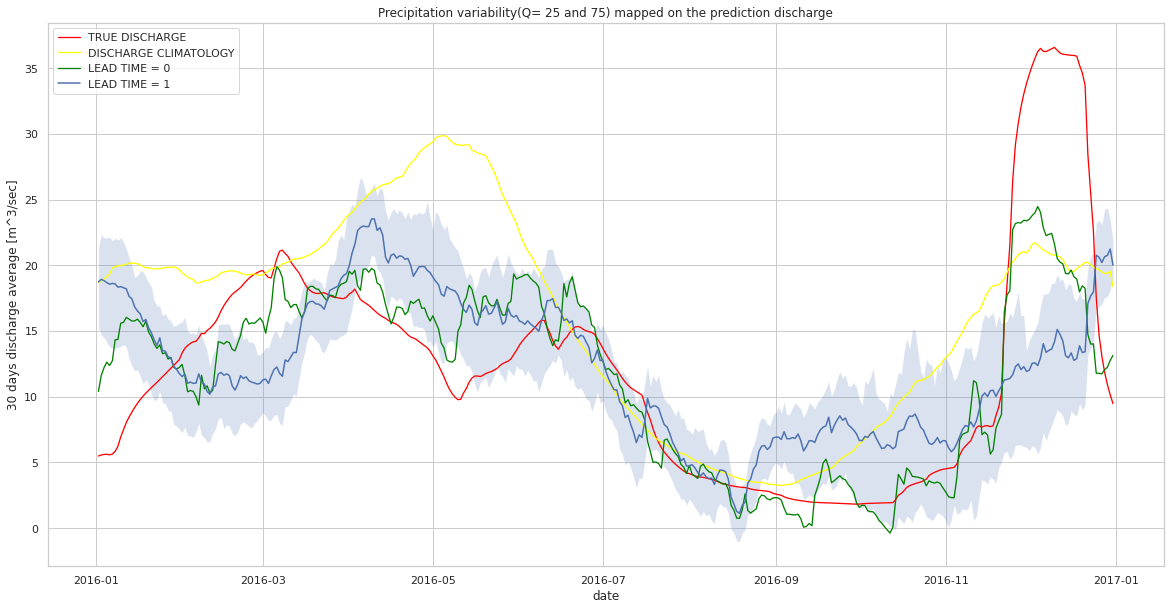

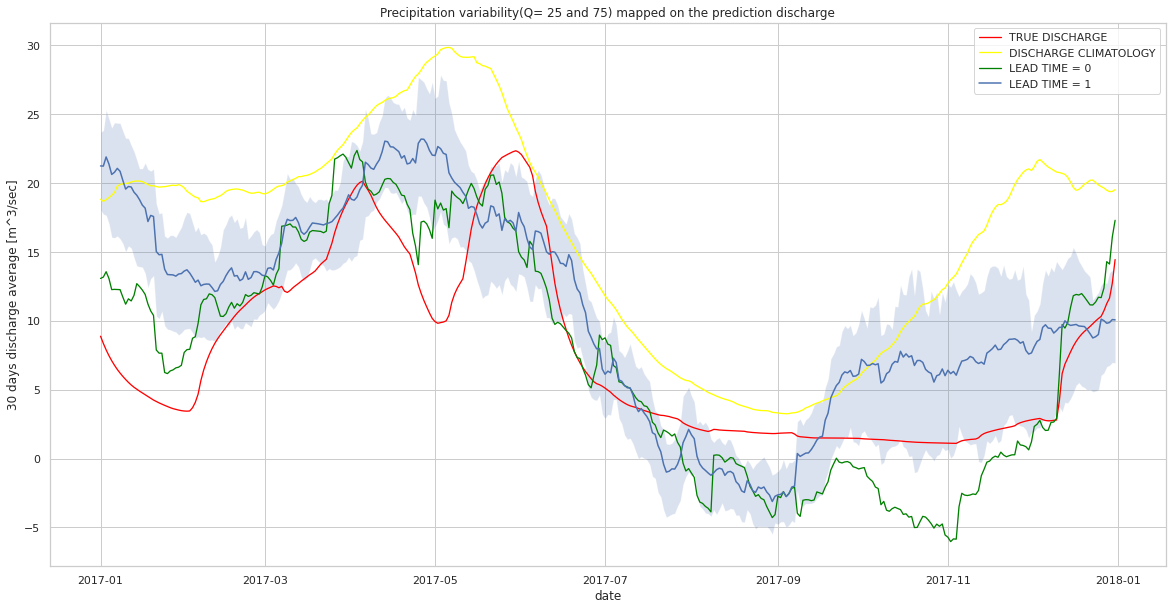

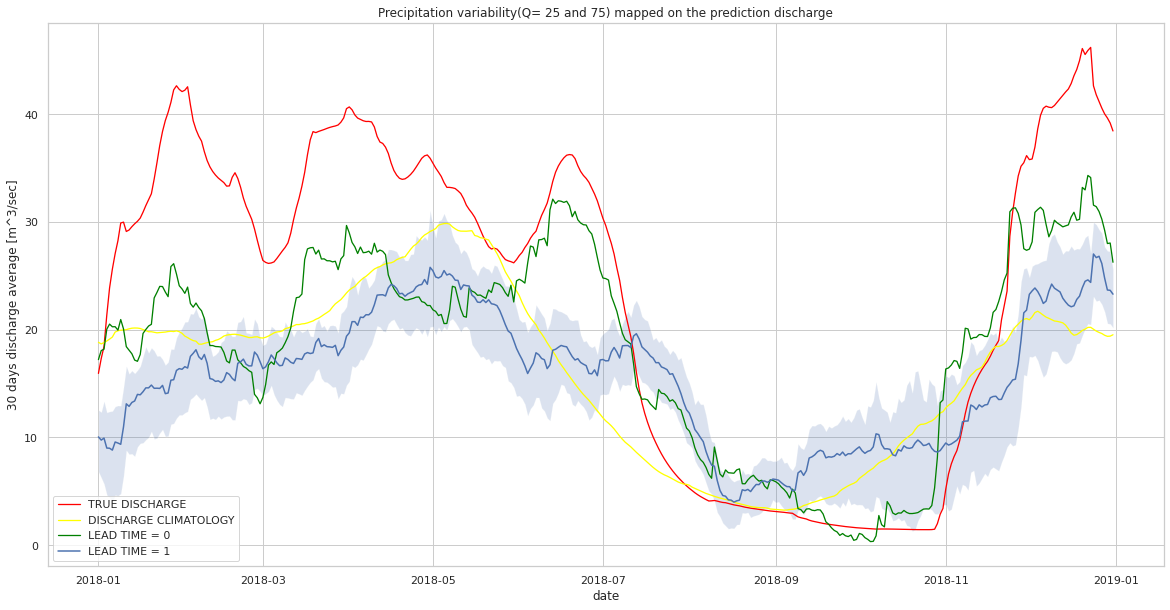

In [47]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4)

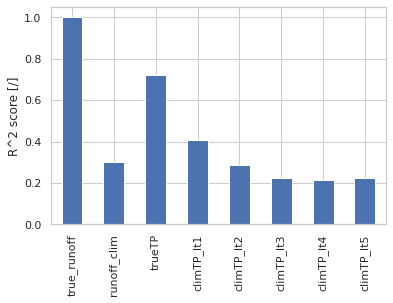

In [48]:
r2_D= evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [49]:
predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat4, C4, eps4, t_length, t_unit, n_splits, linear=True)

In [50]:
climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.dayofyear).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


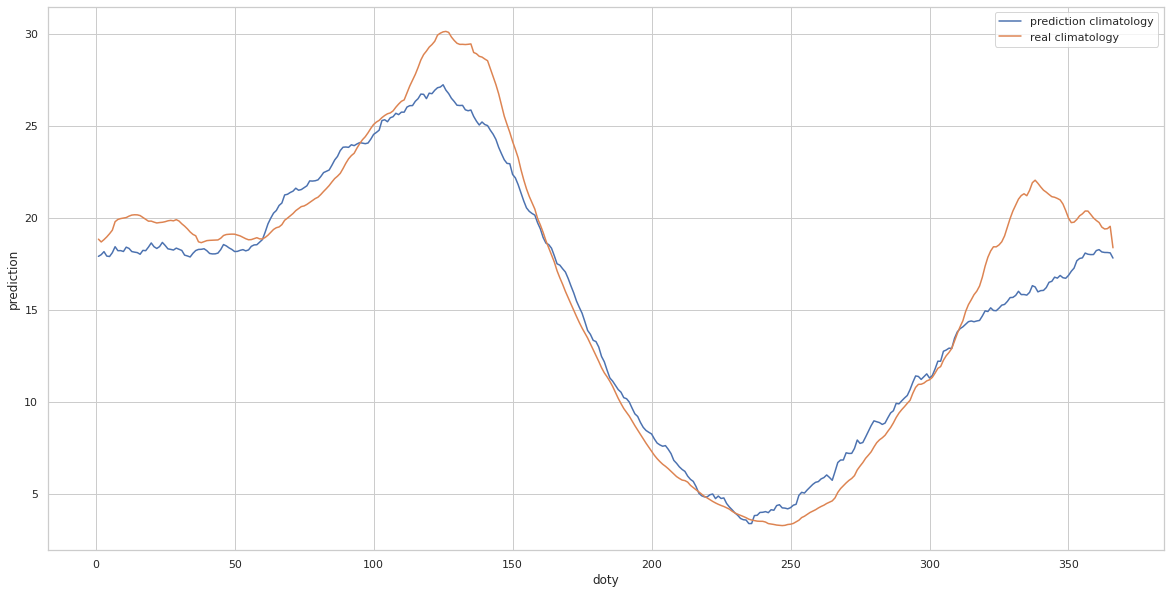

In [51]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

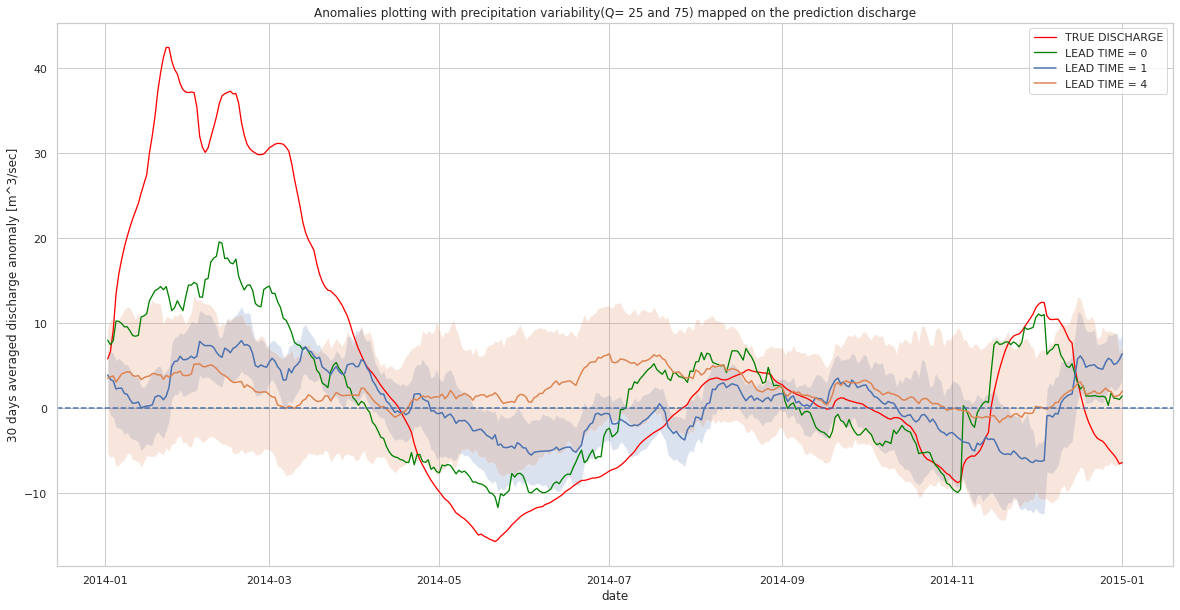

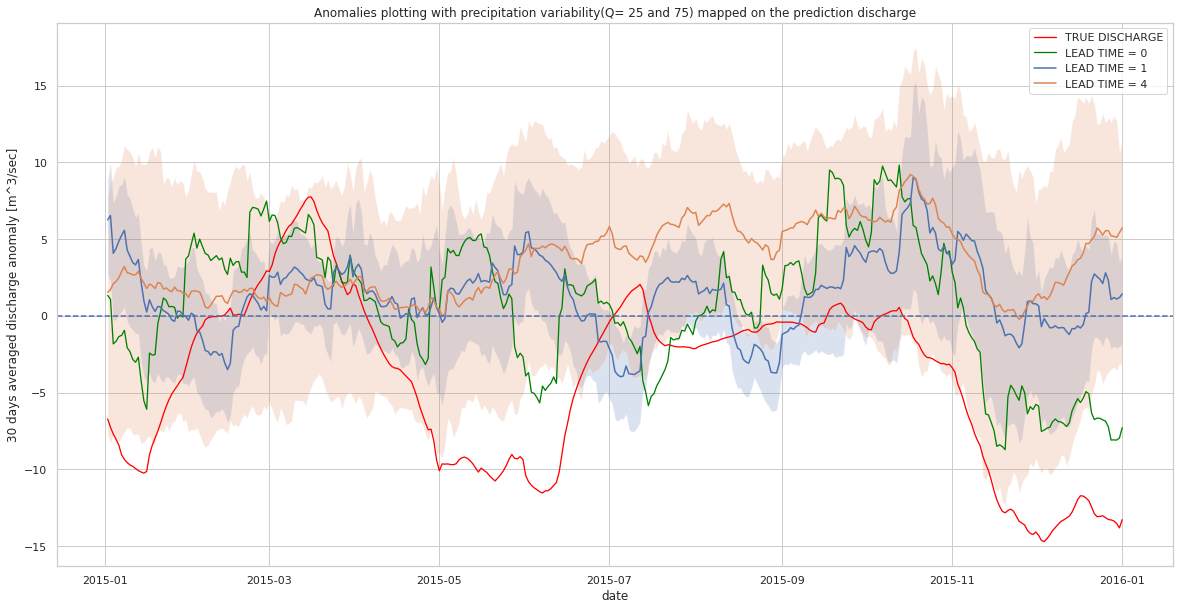

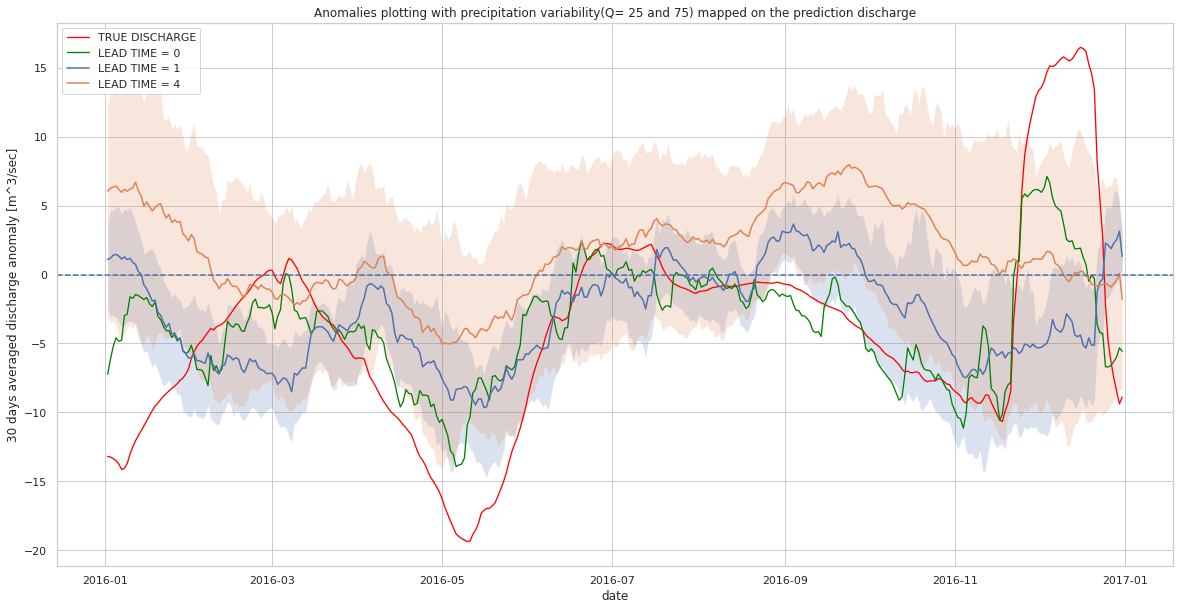

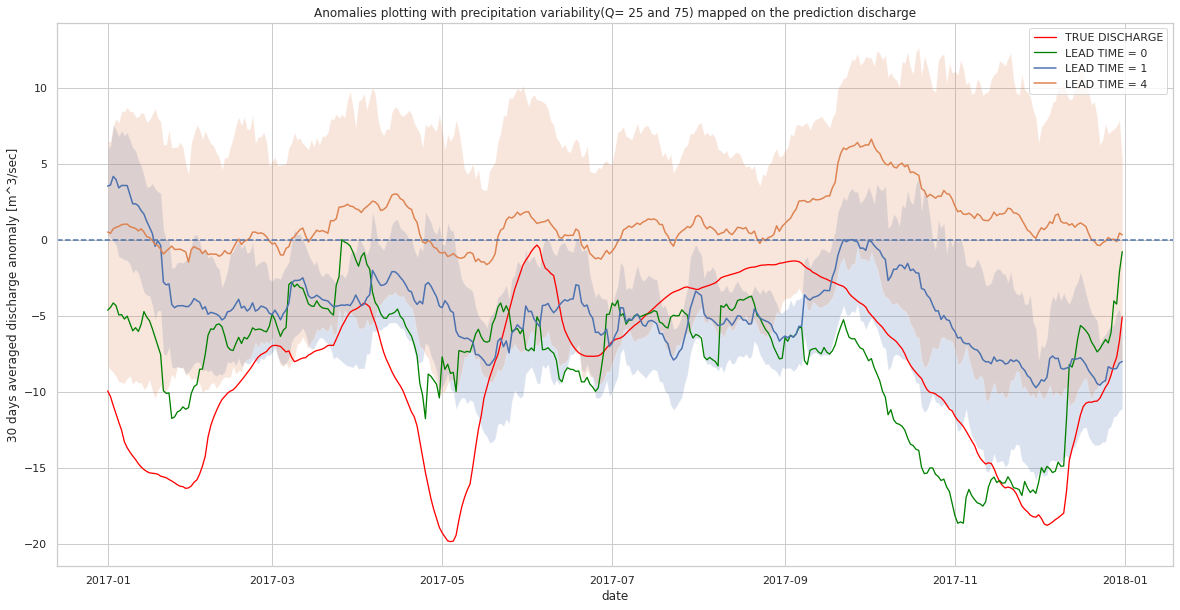

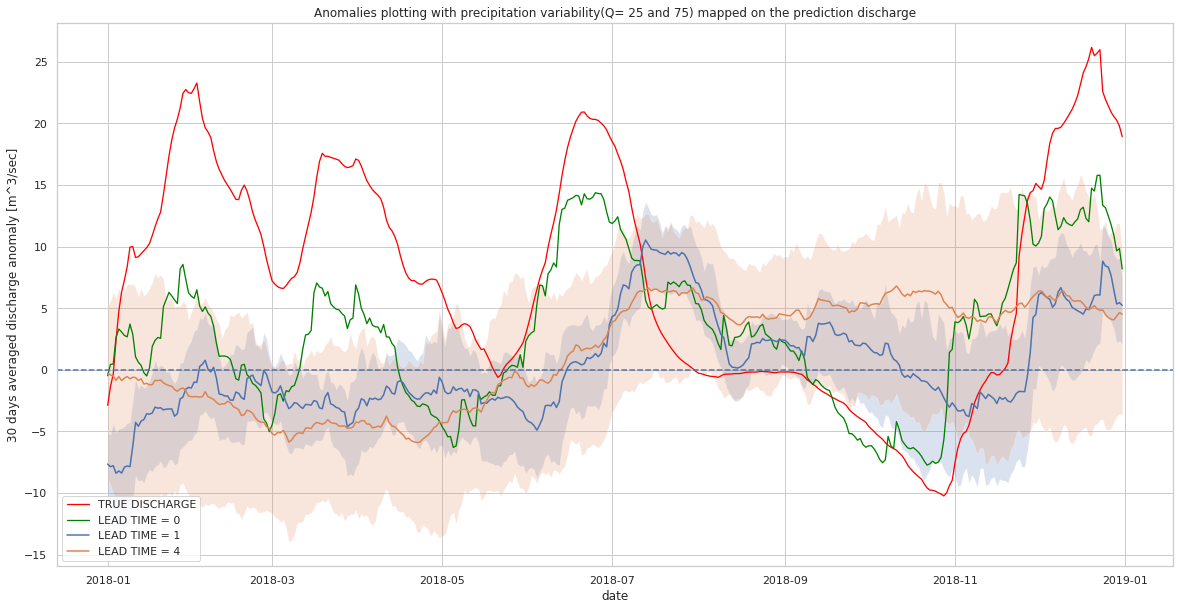

In [52]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split

plot_anomalies(a4)

# COMPARE RESULTS

Text(0, 0.5, 'r^2 [/]')

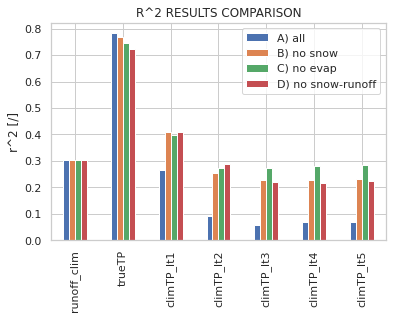

In [59]:
results = pd.concat([r2_A,r2_B,r2_C,r2_D],axis=1)
results.columns=['A) all','B) no snow','C) no evap','D) no snow-runoff']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

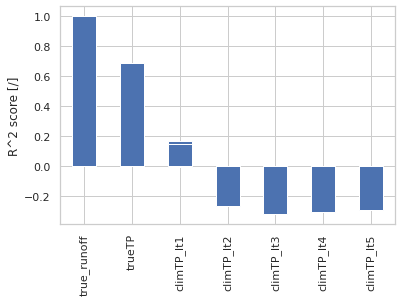

In [54]:
r2_a_D= evaluate_prediction(a4)
r2_a_C= evaluate_prediction(a3)
r2_a_B = evaluate_prediction(a2)
r2_a_A = evaluate_prediction(a)

Text(0.5, 1.0, 'R^2 RESULTS COMPARISON')

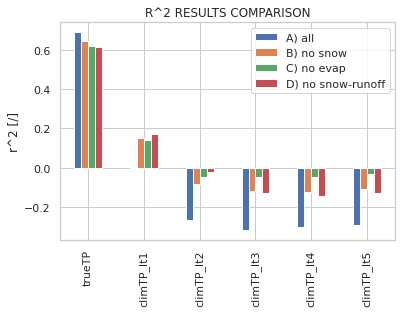

In [55]:
results_a = pd.concat([r2_a_A,r2_a_B,r2_a_C,r2_a_D],axis=1)
results_a.columns=['A) all','B) no snow','C) no evap','D) no snow-runoff']
results_a.iloc[1:].plot.bar()
plt.ylabel('r^2 [/]')
plt.title('R^2 RESULTS COMPARISON')

In [60]:
arrays = [[np.array(np.repeat((t_unit),8),dtype=object),np.array(results.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results.index=index

results


A) all  B) no snow  C) no evap  D) no snow-runoff
t_unit lt                                                              
30     true_runoff  1.000000    1.000000    1.000000           1.000000
       runoff_clim  0.303719    0.303719    0.303719           0.303719
       trueTP       0.781883    0.766375    0.744740           0.722426
       climTP_lt1   0.267072    0.410079    0.396718           0.408669
       climTP_lt2   0.092299    0.255607    0.274913           0.288070
       climTP_lt3   0.059581    0.228424    0.275287           0.222290
       climTP_lt4   0.070359    0.226931    0.279501           0.216586
       climTP_lt5   0.070353    0.233529    0.284861           0.223068

In [58]:
arrays = [[np.array(np.repeat((t_unit),7),dtype=object),np.array(results_a.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results_a.index=index

results_a

A) all  B) no snow  C) no evap  D) no snow-runoff
t_unit lt                                                              
30     true_runoff  1.000000    1.000000    1.000000           1.000000
       trueTP       0.690382    0.646866    0.622216           0.615163
       climTP_lt1  -0.002022    0.150332    0.139290           0.171530
       climTP_lt2  -0.264300   -0.081211   -0.046392          -0.020255
       climTP_lt3  -0.316819   -0.119045   -0.046968          -0.129471
       climTP_lt4  -0.302155   -0.122614   -0.044689          -0.143409
       climTP_lt5  -0.291031   -0.110062   -0.033310          -0.130675

In [63]:
results.to_csv('DROME_linear__30.csv')
results_a.to_csv('DROME_linear__30_a.csv')

In [64]:
from google.colab import files
files.download("DROME_linear__30.csv")
files.download("DROME_linear__30_a.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>